In [3]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import math
import shap
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)

### Read Data

In [4]:
## Read Clean Data From Folder
path = r'C_data'
db_dir = glob.glob(path + "/*.csv")

li = []

for i in db_dir:
    df = pd.read_csv(i, index_col=None, header=0)
    li.append(df)
ori_db = pd.concat(li, ignore_index=True)
wtpc = pd.read_csv('Design Capacity WTP.csv')
master_db = pd.merge(ori_db,wtpc[['wtp','Water Source','Lembangan']],on='wtp',how='left')
master_db['Date'] = pd.to_datetime(master_db['Date'])

### General Data Cleaning

In [5]:
## Define Outliers Removal Function
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 1.5)
    upper_limit = s.mean() + (s.std() * 1.5)
    return ~s.between(lower_limit, upper_limit)

In [6]:
## Rate of change variables ("..._chpctm") vs agaisnt median value of respective WTP
tv = ['Disinfectant_chpctm','pH Adjuster_chpctm','Coagulant_chpctm']
idv = ['pH_avg_chpctm', 'Turbidity_avg_chpctm','Color_avg_chpctm', 'Iron_avg_chpctm', 'Ammonia_avg_chpctm', 'Manganese_avg_chpctm']
master_db[idv] = master_db[idv].fillna(0)
to_c5 = master_db.copy()
to_c5 = to_c5[tv+idv+['Lembangan','wtp','Date']].copy()
to_c5 = to_c5[~to_c5.isin([np.inf, -np.inf]).any(1)].copy()
to_c5 = to_c5.dropna()
ge2 = tv + idv

In [7]:
ge2

['Disinfectant_chpctm',
 'pH Adjuster_chpctm',
 'Coagulant_chpctm',
 'pH_avg_chpctm',
 'Turbidity_avg_chpctm',
 'Color_avg_chpctm',
 'Iron_avg_chpctm',
 'Ammonia_avg_chpctm',
 'Manganese_avg_chpctm']

In [8]:
opp = pd.DataFrame()
for i in ge2:
    
    if i==ge2[0]:
        m0 = to_c5[~to_c5.groupby(['Lembangan','wtp'])[i].apply(is_outlier)][['Lembangan','wtp',i,'Date']]
        opp = opp.append(m0)
    else:
        m1 = to_c5[~to_c5.groupby(['Lembangan','wtp'])[i].apply(is_outlier)][['Lembangan','wtp',i,'Date']]
        opp = pd.merge(opp,m1,on=['Lembangan','wtp','Date'],how='left')

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [9]:
opp

,Lembangan,wtp,Disinfectant_chpctm,Date,pH Adjuster_chpctm,Coagulant_chpctm,pH_avg_chpctm,Turbidity_avg_chpctm,Color_avg_chpctm,Iron_avg_chpctm,Ammonia_avg_chpctm,Manganese_avg_chpctm
0,Sg Bernam,Bernam River Headworks (New),0.000000,2021-04-01,60.000000,95.439739,-0.312500,-47.650931,-15.431349,2.797203,-27.272727,-17.647059
1,Sg Bernam,Bernam River Headworks (New),0.000000,2021-04-02,60.000000,95.439739,1.406250,-54.993191,-1.761847,6.293706,-45.454545,-41.176471
2,Sg Bernam,Bernam River Headworks (New),0.000000,2021-04-03,60.000000,73.724213,2.343750,-57.523831,3.280680,7.692308,-36.363636,-23.529412
3,Sg Bernam,Bernam River Headworks (New),0.000000,2021-04-04,60.000000,153.311618,2.187500,36.904222,143.803159,NaN,45.454545,0.000000
4,Sg Bernam,Bernam River Headworks (New),0.000000,2021-04-05,NaN,117.155266,1.250000,-34.827508,47.812880,4.895105,18.181818,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6328,Sg Tengi,Sungai Tengi,-4.204204,2021-09-26,16.987921,NaN,-0.175131,NaN,NaN,-36.781609,NaN,160.000000
6329,Sg Tengi,Sungai Tengi,-4.204204,2021-09-27,16.422513,25.260960,-7.530648,109.539366,127.479064,NaN,0.000000,20.000000
6330,Sg Tengi,Sungai Tengi,-4.204204,2021-09-28,11.282447,-0.208768,-8.406305,7.154525,16.407739,-37.931034,-23.529412,40.000000
6331,Sg Tengi,Sungai Tengi,-4.204204,2021-09-29,11.282447,-16.492693,-6.129597,13.622999,60.750794,-42.528736,-11.764706,80.000000


In [10]:
opp = opp.dropna()
opp.shape

(3913, 12)

## Modelling (Feature Importance)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

In [12]:
## Random Forest Optimization
def rfopt(Xr_train,y_train,Xr_test,y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10, 20, 30, 40]
    n_estimators = [100, 200, 300]
    for i in max_depth:
        
        for j in n_estimators:
            rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

## Sungai Langat

In [1069]:
wwt = 'Sg Langat'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1070]:
X_train

,pH_avg_chpctm,Turbidity_avg_chpctm,Color_avg_chpctm,Iron_avg_chpctm,Ammonia_avg_chpctm,Manganese_avg_chpctm
3048,1.369863,-18.872410,9.888889,9.090909,42.372881,0.000000
3147,0.754148,176.104298,143.594849,1.428571,38.235294,40.000000
2924,3.044140,14.377901,8.333333,0.000000,1.694915,11.111111
2988,1.217656,76.485905,20.166667,0.000000,16.949153,22.222222
3203,1.508296,325.884034,162.285942,-11.428571,23.529412,30.000000
...,...,...,...,...,...,...
3278,-0.452489,-46.065008,-15.704235,-7.142857,26.470588,10.000000
3345,-0.754148,-53.756400,-71.671313,4.285714,-26.470588,-10.000000
2890,1.369863,-39.250538,-11.111111,9.090909,18.644068,-22.222222
3005,1.826484,-23.480131,-11.111111,0.000000,44.067797,0.000000


In [1071]:
y_train

,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
3048,0.000000,0.555115,0.000000
3147,11.666667,-5.128205,11.029524
2924,0.000000,-0.158604,0.000000
2988,0.000000,0.713719,0.000000
3203,2.500000,-5.000000,16.047116
...,...,...,...
3278,-6.111111,-3.333333,-1.086125
3345,-1.111111,7.820513,2.034572
2890,0.000000,-0.396511,0.000000
3005,0.000000,0.237906,0.000000


In [1072]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,80.45,161.60,12.712199
1,max_depth10 n_est:200,80.51,159.29,12.621014
2,max_depth10 n_est:300,80.44,157.16,12.536347
3,max_depth20 n_est:100,89.85,162.25,12.737739
4,max_depth20 n_est:200,89.91,160.70,12.676750
5,max_depth20 n_est:300,89.94,158.21,12.578156
6,max_depth30 n_est:100,90.11,162.92,12.764012
7,max_depth30 n_est:200,90.20,160.48,12.668070
8,max_depth30 n_est:300,90.21,158.19,12.577361
9,max_depth40 n_est:100,90.11,162.59,12.751078


In [1073]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.175274,0.118858,0.098725
1,Turbidity_avg_chpctm,0.132150,0.180394,0.383296
2,Color_avg_chpctm,0.116449,0.127104,0.136068
3,Iron_avg_chpctm,0.187947,0.136041,0.160626
4,Ammonia_avg_chpctm,0.274053,0.172840,0.119105
5,Manganese_avg_chpctm,0.114128,0.264763,0.102179


R Square Result 89.94%
MSE 158.21


## Sg Klang

In [1074]:
wwt = 'Sg Klang'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1075]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,86.32,165.51,12.865069
1,max_depth10 n_est:200,86.66,164.03,12.807420
2,max_depth10 n_est:300,86.62,163.40,12.782801
3,max_depth20 n_est:100,90.43,166.79,12.914720
4,max_depth20 n_est:200,90.92,167.03,12.924009
5,max_depth20 n_est:300,90.93,165.31,12.857294
6,max_depth30 n_est:100,90.43,166.82,12.915882
7,max_depth30 n_est:200,90.92,166.71,12.911623
8,max_depth30 n_est:300,90.94,165.33,12.858071
9,max_depth40 n_est:100,90.43,166.82,12.915882


In [1076]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.399854,0.255426,0.212185
1,Turbidity_avg_chpctm,0.161775,0.382469,0.432042
2,Color_avg_chpctm,0.116894,0.150343,0.238489
3,Iron_avg_chpctm,0.173466,0.101805,0.060055
4,Ammonia_avg_chpctm,0.130720,0.094535,0.053282
5,Manganese_avg_chpctm,0.017291,0.015422,0.003949


R Square Result 90.93%
MSE 165.31


## Sg Selangor

In [1077]:
wwt = 'Sg Selangor'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1078]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,72.14,170.94,13.074402
1,max_depth10 n_est:200,72.35,171.56,13.098091
2,max_depth10 n_est:300,72.33,170.80,13.069047
3,max_depth20 n_est:100,87.47,177.03,13.305262
4,max_depth20 n_est:200,87.65,176.94,13.301880
5,max_depth20 n_est:300,87.71,176.18,13.273281
6,max_depth30 n_est:100,88.14,178.10,13.345411
7,max_depth30 n_est:200,88.37,177.62,13.327415
8,max_depth30 n_est:300,88.46,176.59,13.288717
9,max_depth40 n_est:100,88.13,177.40,13.319159


In [1079]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.160562,0.165902,0.112566
1,Turbidity_avg_chpctm,0.234119,0.236098,0.406530
2,Color_avg_chpctm,0.229019,0.220031,0.202706
3,Iron_avg_chpctm,0.151722,0.138945,0.107897
4,Ammonia_avg_chpctm,0.129025,0.152605,0.095559
5,Manganese_avg_chpctm,0.095553,0.086419,0.074742


R Square Result 87.71%
MSE 176.18


## Sg Semantan

In [1080]:
wwt = 'Sg Semantan'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1081]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,92.33,234.35,15.308494
1,max_depth10 n_est:200,92.57,230.56,15.184202
2,max_depth10 n_est:300,92.66,233.98,15.296405
3,max_depth20 n_est:100,92.44,234.28,15.306208
4,max_depth20 n_est:200,92.74,232.15,15.236469
5,max_depth20 n_est:300,92.83,234.45,15.311760
6,max_depth30 n_est:100,92.44,234.24,15.304901
7,max_depth30 n_est:200,92.74,232.12,15.235485
8,max_depth30 n_est:300,92.83,234.46,15.312087
9,max_depth40 n_est:100,92.44,234.24,15.304901


In [1082]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.101477,0.198384,0.251226
1,Turbidity_avg_chpctm,0.198466,0.087250,0.376016
2,Color_avg_chpctm,0.198212,0.168066,0.081647
3,Iron_avg_chpctm,0.377428,0.447788,0.167994
4,Ammonia_avg_chpctm,0.041385,0.042310,0.061462
5,Manganese_avg_chpctm,0.083032,0.056202,0.061656


R Square Result 92.83%
MSE 234.45


## Sg Tengi

In [1083]:
wwt = 'Sg Tengi'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1084]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,92.34,183.27,13.537725
1,max_depth10 n_est:200,92.26,182.34,13.503333
2,max_depth10 n_est:300,92.42,183.36,13.541049
3,max_depth20 n_est:100,92.73,185.76,13.629380
4,max_depth20 n_est:200,92.73,183.45,13.544372
5,max_depth20 n_est:300,92.86,184.48,13.582341
6,max_depth30 n_est:100,92.73,185.75,13.629013
7,max_depth30 n_est:200,92.73,183.44,13.544002
8,max_depth30 n_est:300,92.86,184.47,13.581973
9,max_depth40 n_est:100,92.73,185.75,13.629013


In [1085]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.133225,0.344711,0.043770
1,Turbidity_avg_chpctm,0.154190,0.229853,0.802068
2,Color_avg_chpctm,0.257187,0.255153,0.078252
3,Iron_avg_chpctm,0.221609,0.065914,0.039759
4,Ammonia_avg_chpctm,0.170508,0.060554,0.025471
5,Manganese_avg_chpctm,0.063282,0.043816,0.010679


R Square Result 92.86%
MSE 184.48


## Sg Bernam

In [1086]:
wwt = 'Sg Bernam'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1087]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,88.12,600.92,24.513670
1,max_depth10 n_est:200,88.22,612.22,24.743080
2,max_depth10 n_est:300,88.21,613.03,24.759443
3,max_depth20 n_est:100,93.19,608.65,24.670833
4,max_depth20 n_est:200,93.30,617.98,24.859204
5,max_depth20 n_est:300,93.35,616.24,24.824182
6,max_depth30 n_est:100,93.25,608.61,24.670022
7,max_depth30 n_est:200,93.36,618.35,24.866644
8,max_depth30 n_est:300,93.39,617.15,24.842504
9,max_depth40 n_est:100,93.25,608.61,24.670022


In [1088]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.600322,0.628616,0.260493
1,Turbidity_avg_chpctm,0.097559,0.054892,0.124362
2,Color_avg_chpctm,0.095286,0.141395,0.349935
3,Iron_avg_chpctm,0.085590,0.057930,0.109993
4,Ammonia_avg_chpctm,0.061638,0.078290,0.084674
5,Manganese_avg_chpctm,0.059605,0.038878,0.070543


R Square Result 93.35%
MSE 616.24


## General

In [13]:
to_c7 = opp.copy()
to_c7.shape
## Common Target
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

(3913, 12)

In [14]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,59.33,238.91,15.456714
1,max_depth10 n_est:200,59.48,238.34,15.438264
2,max_depth10 n_est:300,59.58,237.57,15.413306
3,max_depth20 n_est:100,85.60,238.87,15.455420
4,max_depth20 n_est:200,85.86,237.53,15.412008
5,max_depth20 n_est:300,85.99,237.17,15.400325
6,max_depth30 n_est:100,89.62,240.14,15.496451
7,max_depth30 n_est:200,89.90,238.37,15.439236
8,max_depth30 n_est:300,90.01,237.43,15.408764
9,max_depth40 n_est:100,89.83,239.72,15.482894


In [15]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]

In [16]:
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.219462,0.365170,0.297001
1,Turbidity_avg_chpctm,0.187635,0.133518,0.182234
2,Color_avg_chpctm,0.151427,0.168363,0.253083
3,Iron_avg_chpctm,0.185217,0.118387,0.086216
4,Ammonia_avg_chpctm,0.135053,0.107841,0.089393
5,Manganese_avg_chpctm,0.121206,0.106720,0.092073


R Square Result 85.99%
MSE 237.17


In [17]:
## User Defined Weightage for each Chemical Products

## General Random Method
weight = np.array([0.3, 0.3, 0.4])

## Weightage Based on Cost
weight_c = np.array([0.395, 0.1224, 0.4826])

## Weightage Based on Dosing 
weight_d = np.array([0.1064, 0.1969, 0.6967])

In [18]:
## Refined Weightage
fw = RDF.iloc[:,1:].dot(weight_d)
fwc = RDF.iloc[:,1:].dot(weight_c)
#fwd = RDF.iloc[:,1:].dot(weight_d) # (Will be focus on this as user has agreed on this weightage)

## New Computation - Ikmal

In [530]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import glob

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.concat([pd.read_csv(file, index_col=None, header=0) for file in db_dir])
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions
condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
jam3.loc[condition, 'Lembangan'] = 'Sungai Selangor Upstream'
jam3 = pd.concat([jam3, pd.get_dummies(jam3['Lembangan'])], axis=1)

jam4 = jam3[(jam3['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (jam3['wtp'] != 'Bukit Tampoi New')].copy()

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date',
           'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
           'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
           'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
           'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
           'Soda Ash (Post)', 'Soda_Ash_T', 'Hydrated_Lime_T', 'Hydrated_Lime_Pow_T', 'Liquid_Chlorine_T',
           'Hydrated_Lime_T_Pow']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

## Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10]
    n_estimators = [100]
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")


,fea,rscore,MSE,Error
0,max_depth10 n_est:100,94.8,2.05,1.431782


,Feature,Kibbled Aluminium Sulphate,Flopam FA 920 PWG,Liquid Chlorine,Sodium Silico Fluoride,Liquid Aluminium Sulphate,Soda Ash,Hydrated Lime,Liquid Polyaluminium Chloride,Sodium Aluminosilicate,Sodium Fluoride,Superfloc C 591 PWG,Aluminium Chlorohydrate,Flopam AH 912 PWG,Hydrated Lime (Powder),Flopam FO 4190 PWG,Flopam FO 4290 PWG,Polyelectrolyte AN 910 PWG,Microsand,Activated Carbon,Flopam FL 4520 PWG,Modified Liquid Alum,Potassium Permanganate,Polymer Tianfloc C3080,Sodium Hypochlorite,Liquid Polyaluminium Chloride (mg/L),Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L),Sodium Silico Fluoride (mg/L),Sg Bernam,Sg Klang,Sg Langat,Sg Selangor,Sg Semantan,Sg Tengi,Sungai Selangor Upstream
0,pH_avg,0.119288,0.179037,0.194421,0.187577,0.241703,0.108098,0.218347,0.498968,0.0,0.184789,0.879501,0.752319,0.045726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004635,0.0,0.336908,0.708962,0.107009,0.129033,0.116725,0.289235,0.164982,0.048231,0.144268,0.161232,0.224284,0.161514
1,Turbidity_avg,0.210365,0.377299,0.162258,0.172584,0.123898,0.072438,0.083311,0.049623,0.0,0.071947,0.015753,0.038271,0.129829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152872,0.0,0.047966,0.019325,0.131217,0.120941,0.145071,0.101212,0.054630,0.016228,0.074875,0.002518,0.080988,0.060586
2,Color_avg,0.177892,0.116533,0.229795,0.175157,0.189695,0.483124,0.127972,0.131722,0.0,0.046601,0.019149,0.017813,0.087559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298258,0.0,0.211832,0.025846,0.398493,0.343397,0.386315,0.221389,0.398027,0.072633,0.298074,0.041630,0.359322,0.268754
3,Iron_avg,0.244264,0.200187,0.145690,0.218941,0.180163,0.076109,0.163441,0.083048,0.0,0.283619,0.021686,0.040767,0.201432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521500,0.0,0.145675,0.242288,0.147464,0.163467,0.152606,0.215190,0.166272,0.597618,0.244632,0.695930,0.212674,0.238851
4,Ammonia_avg,0.131626,0.037589,0.194625,0.194325,0.195874,0.034122,0.332906,0.104410,0.0,0.310066,0.054604,0.142371,0.500124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005457,0.0,0.109410,0.002944,0.165719,0.193799,0.157591,0.116379,0.019212,0.181503,0.167690,0.002336,0.089935,0.095536
5,Manganese_avg,0.116566,0.089355,0.073211,0.051415,0.068668,0.226109,0.074024,0.132228,0.0,0.102977,0.009307,0.008459,0.035331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017278,0.0,0.148210,0.000635,0.050098,0.049362,0.041692,0.056595,0.196877,0.083787,0.070461,0.096354,0.032797,0.174760


R Square Result 96.89%
MSE 1.95


### Testing other algorithm

In [962]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
import numpy as np
import glob

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.concat([pd.read_csv(file, index_col=None, header=0) for file in db_dir])
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions for sungai selangor upstream reclassification
condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
jam3.loc[condition, 'Lembangan'] = 'Sg Selangor Upstream'
jam3 = pd.concat([jam3, pd.get_dummies(jam3['Lembangan'])], axis=1)

jam4 = jam3[(jam3['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (jam3['wtp'] != 'Bukit Tampoi New')].copy()

#select the lembangan
jam4 = jam4[jam4['Lembangan'] == 'Sg Tengi']

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date',
           'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
           'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
           'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
           'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
           'Soda Ash (Post)', 'Soda_Ash_T', 'Hydrated_Lime_T', 'Hydrated_Lime_Pow_T', 'Liquid_Chlorine_T',
           'Hydrated_Lime_T_Pow']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

## Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10]
    n_estimators = [100]
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

max_depth = 20
rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")


,fea,rscore,MSE,Error
0,max_depth10 n_est:100,99.75,0.11,0.331662


,Feature,Kibbled Aluminium Sulphate,Flopam FA 920 PWG,Liquid Chlorine,Sodium Silico Fluoride,Liquid Aluminium Sulphate,Soda Ash,Hydrated Lime,Liquid Polyaluminium Chloride,Sodium Aluminosilicate,Sodium Fluoride,Superfloc C 591 PWG,Aluminium Chlorohydrate,Flopam AH 912 PWG,Hydrated Lime (Powder),Flopam FO 4190 PWG,Flopam FO 4290 PWG,Polyelectrolyte AN 910 PWG,Microsand,Activated Carbon,Flopam FL 4520 PWG,Modified Liquid Alum,Potassium Permanganate,Polymer Tianfloc C3080,Sodium Hypochlorite,Liquid Polyaluminium Chloride (mg/L),Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L),Sodium Silico Fluoride (mg/L),Sg Bernam,Sg Klang,Sg Langat,Sg Selangor,Sg Selangor Upstream,Sg Semantan,Sg Tengi
0,pH_avg,0.037225,0.0,0.201406,0.0,0.0,0.0,0.0,0.0,0.0,0.149989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Turbidity_avg,0.467782,0.0,0.118502,0.0,0.0,0.0,0.0,0.0,0.0,0.055190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Color_avg,0.349062,0.0,0.178175,0.0,0.0,0.0,0.0,0.0,0.0,0.094965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Iron_avg,0.028587,0.0,0.173424,0.0,0.0,0.0,0.0,0.0,0.0,0.312641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ammonia_avg,0.039723,0.0,0.152193,0.0,0.0,0.0,0.0,0.0,0.0,0.260340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Manganese_avg,0.077621,0.0,0.176299,0.0,0.0,0.0,0.0,0.0,0.0,0.126876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


R Square Result 100.0%
MSE 0.1


In [590]:
mm = [
        'Soda_Ash',
        'Liquid_Chlorine',
        'Liquid_Polyaluminium_Chloride',
        'Hydrated_Lime',
        'Aluminium_Sulphate']

for i in mm:
    print(i)
    jam4[jam4['wtp'] == 'Sungai Selangor Fasa 3'][i].sum()

Soda_Ash


0.0

Liquid_Chlorine


1921.015811114

Liquid_Polyaluminium_Chloride


10622.357416629999

Hydrated_Lime


3051.0011617620003

Aluminium_Sulphate


0.0

### Using CV to overcome overfit issue

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import glob

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.read_csv('CP_data\ChemPare_SgSel.csv', index_col=None, header=0)
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions for sungai selangor upstream reclassification
#condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
# jam3.loc[condition, 'Lembangan'] = 'Sg Selangor Upstream'

wtp_exclude_lst = ['Bernam River Headworks (Old)',
 'Bukit Tampoi New',
 'Salak Tinggi',
 'Sungai Serai',
 'Bernam River Headworks (New)']

jam4 = jam3.copy().fillna(0)

for i in wtp_exclude_lst:
    jam4 = jam4[(jam4['wtp'] != i) ]
#select the lembangan
jam4 = jam4[jam4['wtp'] == 'Batang Kali']
jam4 = pd.concat([jam4, pd.get_dummies(jam4['wtp'])], axis=1)

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'Date']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

#Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test,X,y):
    score = {"fea":[],"CV_mean_MSE":[],"CV_mean_rscore":[]}
    max_depth = [1]
    n_estimators = [1]
    scoring = ['neg_root_mean_squared_error', 'r2']
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=j, max_depth=i, random_state=0))#.fit(Xr_train, y_train)
            
            cv_results = cross_validate(rf, X, y, cv=10, scoring=scoring, return_train_score=False)
            #rs = round(rf.score(Xr_train,y_train)*100,2)
            #rf_pr = rf.predict(Xr_test)
            #ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            #score["rscore"].append(rs)
            #score["MSE"].append(ms)
            score['CV_mean_MSE'].append(round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2))
            score['CV_mean_rscore'].append(round(np.mean(cv_results["test_r2"]), 2))
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test,X,y)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['CV_mean_MSE'])
cal



,fea,CV_mean_MSE,CV_mean_rscore,Error
0,max_depth1 n_est:1,0.29,-0.9,0.538516


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import glob


path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.read_csv('CP_data\ChemPare_SgSel_2.csv', index_col=None, header=0)
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions for sungai selangor upstream reclassification
#condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
# jam3.loc[condition, 'Lembangan'] = 'Sg Selangor Upstream'

wtp_exclude_lst = ['Bernam River Headworks (Old)',
 'Bukit Tampoi New',
 'Salak Tinggi',
 'Sungai Serai',
 'Bernam River Headworks (New)']

jam4 = jam3.copy().fillna(0)

for i in wtp_exclude_lst:
    jam4 = jam4[(jam4['wtp'] != i) ]
#select the lembangan
#jam4 = jam4[jam4['wtp'] == 'Sungai Selangor Fasa 2 Stream C']
jam4['Soda_Ash'] = jam4.apply(lambda row: row['Soda_Ash_T'] + row['Soda Ash'], axis=1)
jam4['Liquid_Chlorine'] = jam4.apply(lambda row: row['Liquid_Chlorine_T'] + row['Liquid Chlorine'], axis=1)
jam4['Liquid_Polyaluminium_Chloride'] = jam4.apply(lambda row: row['Liquid Polyaluminium Chloride (mg/L)'] + row['Liquid Polyaluminium Chloride'], axis=1)
jam4['Hydrated_Lime'] = jam4.apply(lambda row: row['Hydrated Lime'] + row['Hydrated_Lime_Pow_T'], axis=1)
jam4['Aluminium_Sulphate'] = jam4.apply(lambda row: row['Liquid Aluminium Sulphate'] + row['Kibbled Aluminium Sulphate'], axis=1)
jam4['Sodium_Silico_Fluoride'] = jam4.apply(lambda row: row['Sodium Silico Fluoride'] + row['Sodium Silico Fluoride (mg/L)'], axis=1)

jam4 = jam4.drop(['Sodium Aluminosilicate','Flopam FA 920 PWG','Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L)','Flopam FO 4290 PWG','Sodium_Silico_Fluoride','Microsand','Sodium Silico Fluoride (mg/L)','Sodium Silico Fluoride','Kibbled Aluminium Sulphate','Liquid Aluminium Sulphate','Hydrated Lime','Hydrated_Lime_Pow_T','Soda_Ash_T','Soda Ash','Liquid_Chlorine_T','Liquid Chlorine','Liquid Polyaluminium Chloride (mg/L)','Liquid Polyaluminium Chloride'],axis = 1)
jam4 = pd.concat([jam4, pd.get_dummies(jam4['wtp'])], axis=1)

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'Date']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

# MLD_dict = {'Batang Kali':17,
#        'Kuala Kubu Bharu':22, 'Rasa':809,
#         'Rantau Panjang New':120, 'Rantau Panjang Old':120, 'Sungai Rangkap':23,
#        'Sungai Selangor Fasa 1':3501, 'Sungai Selangor Fasa 3':3074,'Sungai Selangor Fasa 2 Stream C':3617}

# jam4_i = jam4.copy()
# for key, value in MLD_dict.items():
#     # Check if the key is in the DataFrame
#     if key in jam4_i['wtp'].tolist():
#         # Set the value in the new column where the feature matches the key
#         jam4_i.loc[jam4_i['wtp'] == key, 'MLD'] = value

# chem = [
#         'Soda_Ash',
#         'Liquid_Chlorine',
#         'Liquid_Polyaluminium_Chloride',
#         'Hydrated_Lime',
#         'Aluminium_Sulphate']

# for i in chem:
#     jam4_i[i] = jam4_i[i]/jam4_i['MLD']

# jam4_i = jam4_i.drop('MLD',axis = 1)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)



In [46]:
jam4

,wtp,pH_avg,Date,Turbidity_avg,Color_avg,Iron_avg,Ammonia_avg,Manganese_avg,Month,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate,Batang Kali,Kuala Kubu Bharu,Rantau Panjang New,Rantau Panjang Old,Rasa,Sungai Rangkap,Sungai Selangor Fasa 1,Sungai Selangor Fasa 2 Stream C,Sungai Selangor Fasa 3
0,Batang Kali,6.77,2021-04-01,28.75,4.96,0.26,0.28,0.02,4,1.05,2.380000,0.000000,0.000000,14.23,1,0,0,0,0,0,0,0,0
1,Batang Kali,6.65,2021-04-02,5.67,0.42,0.22,0.12,0.02,4,1.01,2.360000,0.000000,0.000000,13.33,1,0,0,0,0,0,0,0,0
2,Batang Kali,6.61,2021-04-03,14.72,0.42,0.13,0.22,0.02,4,0.98,2.260000,0.000000,0.000000,16.47,1,0,0,0,0,0,0,0,0
3,Batang Kali,6.60,2021-04-04,9.50,3.42,0.22,0.47,0.04,4,1.03,2.360000,0.000000,0.000000,16.32,1,0,0,0,0,0,0,0,0
4,Batang Kali,6.61,2021-04-05,9.01,0.17,0.14,0.15,0.02,4,1.05,2.350000,0.000000,0.000000,17.09,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,Sungai Selangor Fasa 3,5.63,2021-09-26,237.78,31.17,2.98,0.17,0.46,9,0.00,6.042845,37.260145,8.515733,0.00,0,0,0,0,0,0,0,0,1
3000,Sungai Selangor Fasa 3,5.52,2021-09-27,196.33,31.92,2.64,0.15,0.55,9,0.00,6.514619,41.511501,8.710183,0.00,0,0,0,0,0,0,0,0,1
3001,Sungai Selangor Fasa 3,5.54,2021-09-28,192.42,32.25,1.89,0.20,0.38,9,0.00,5.035667,36.873714,8.627555,0.00,0,0,0,0,0,0,0,0,1
3002,Sungai Selangor Fasa 3,5.54,2021-09-29,263.42,26.00,2.63,0.24,0.57,9,0.00,5.355148,41.047287,8.724761,0.00,0,0,0,0,0,0,0,0,1


In [47]:
jam4

,wtp,pH_avg,Date,Turbidity_avg,Color_avg,Iron_avg,Ammonia_avg,Manganese_avg,Month,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate,Batang Kali,Kuala Kubu Bharu,Rantau Panjang New,Rantau Panjang Old,Rasa,Sungai Rangkap,Sungai Selangor Fasa 1,Sungai Selangor Fasa 2 Stream C,Sungai Selangor Fasa 3
0,Batang Kali,6.77,2021-04-01,28.75,4.96,0.26,0.28,0.02,4,1.05,2.380000,0.000000,0.000000,14.23,1,0,0,0,0,0,0,0,0
1,Batang Kali,6.65,2021-04-02,5.67,0.42,0.22,0.12,0.02,4,1.01,2.360000,0.000000,0.000000,13.33,1,0,0,0,0,0,0,0,0
2,Batang Kali,6.61,2021-04-03,14.72,0.42,0.13,0.22,0.02,4,0.98,2.260000,0.000000,0.000000,16.47,1,0,0,0,0,0,0,0,0
3,Batang Kali,6.60,2021-04-04,9.50,3.42,0.22,0.47,0.04,4,1.03,2.360000,0.000000,0.000000,16.32,1,0,0,0,0,0,0,0,0
4,Batang Kali,6.61,2021-04-05,9.01,0.17,0.14,0.15,0.02,4,1.05,2.350000,0.000000,0.000000,17.09,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,Sungai Selangor Fasa 3,5.63,2021-09-26,237.78,31.17,2.98,0.17,0.46,9,0.00,6.042845,37.260145,8.515733,0.00,0,0,0,0,0,0,0,0,1
3000,Sungai Selangor Fasa 3,5.52,2021-09-27,196.33,31.92,2.64,0.15,0.55,9,0.00,6.514619,41.511501,8.710183,0.00,0,0,0,0,0,0,0,0,1
3001,Sungai Selangor Fasa 3,5.54,2021-09-28,192.42,32.25,1.89,0.20,0.38,9,0.00,5.035667,36.873714,8.627555,0.00,0,0,0,0,0,0,0,0,1
3002,Sungai Selangor Fasa 3,5.54,2021-09-29,263.42,26.00,2.63,0.24,0.57,9,0.00,5.355148,41.047287,8.724761,0.00,0,0,0,0,0,0,0,0,1


In [4]:
#Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test,X,y):
    score = {"fea":[],"CV_mean_MSE":[],"CV_mean_rscore":[]}
    max_depth = [1,5,10,20,50,100]
    n_estimators = [1,5,10,20,30,50,100]
    scoring = ['neg_root_mean_squared_error', 'r2']
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=j, max_depth=i, random_state=0))#.fit(Xr_train, y_train)
            
            cv_results = cross_validate(rf, X, y, cv=10, scoring=scoring, return_train_score=False)
            #rs = round(rf.score(Xr_train,y_train)*100,2)
            #rf_pr = rf.predict(Xr_test)
            #ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            #score["rscore"].append(rs)
            #score["MSE"].append(ms)
            score['CV_mean_MSE'].append(round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2))
            score['CV_mean_rscore'].append(round(np.mean(cv_results["test_r2"]), 2))
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test,X,y)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['CV_mean_MSE'])
cal



NameError: name 'gc' is not defined

In [21]:
max_depth = 50
rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_2 = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=max_depth, random_state=0))
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

scoring = ['neg_root_mean_squared_error', 'r2']
cv_results = cross_validate(rf_2, X, y, cv=10, scoring=scoring, return_train_score=False)

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF


# Print results
print(f'CV Mean RMSE: {round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2)}')
print(f'CV RMSE Std: {round(np.std(cv_results["test_neg_root_mean_squared_error"]), 2)}')
print(f'CV Mean R2: {round(np.mean(cv_results["test_r2"]), 2)}')
print(f'CV R2 Std: {round(np.std(cv_results["test_r2"]), 2)}')
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")



,Feature,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate,Batang Kali,Kuala Kubu Bharu,Rantau Panjang New,Rantau Panjang Old,Rasa,Sungai Rangkap,Sungai Selangor Fasa 1,Sungai Selangor Fasa 2 Stream C,Sungai Selangor Fasa 3
0,pH_avg,0.396239,0.331600,0.243576,0.391643,0.145599,0.180600,0.708765,0.159244,0.188903,0.154447,0.220833,0.099848,0.204924,0.603501
1,Turbidity_avg,0.118581,0.141134,0.060481,0.086291,0.091455,0.092150,0.023879,0.058922,0.056035,0.044851,0.108567,0.112107,0.038807,0.019146
2,Color_avg,0.103867,0.156126,0.364268,0.114111,0.387116,0.204759,0.069958,0.265836,0.214043,0.173993,0.191915,0.459072,0.413847,0.237155
3,Iron_avg,0.234066,0.178258,0.205310,0.232372,0.150760,0.251830,0.154404,0.141883,0.066890,0.390609,0.268562,0.021065,0.137585,0.017863
4,Ammonia_avg,0.065105,0.096003,0.095874,0.101785,0.176049,0.132566,0.020910,0.193690,0.349271,0.191267,0.087765,0.269487,0.170862,0.091698
5,Manganese_avg,0.082141,0.096879,0.030491,0.073799,0.049021,0.138095,0.022083,0.180424,0.124858,0.044832,0.122358,0.038420,0.033975,0.030637


CV Mean RMSE: 0.97
CV RMSE Std: 0.32
CV Mean R2: 0.87
CV R2 Std: 0.07
R Square Result 100.0%
MSE 3.05


In [22]:
#Compute the new weight for each of the ph,turbidity, color, iron, ammonia and manganese using the 
#feature importance of non grouped chemical result. The feature importance then multiplied with the ratio 
#actual volume from all the materials. 

# define list of columns to exclude
exclude_ct = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date', 
              'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
              'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
              'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
              'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
              'Soda Ash (Post)', 'Sg Klang', 'Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam',
              'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg','Batang Kali',
'Rasa',
'Sungai Selangor Fasa 2 Stream C',
'Sungai Rangkap',
'Kuala Kubu Bharu',
'Rantau Panjang New',
'Rantau Panjang Old',
'Sungai Selangor Fasa 1',
'Sungai Selangor Fasa 3','Sungai Selangor Fasa 2 Stream C'
]

# calculate the weight of each feature
weight_pd = pd.DataFrame(jam4.sum(), columns=['weight']).reset_index().rename(columns={'index': 'Feature'})
weight_pd = weight_pd[~weight_pd['Feature'].isin(exclude_ct)]

# calculate the percentage of each feature
weight_pd['chem_ratio'] = weight_pd['weight'].div(weight_pd['weight'].sum())

# create a new dataframe without excluded features
#RDF_ex = RDF.drop(['Sg Klang','Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam','Sg Selangor Upstream'], axis=1)

# create a new dataframe without excluded features
RDF_ex = RDF.drop([ 'Batang Kali',
       'Kuala Kubu Bharu', 'Rasa',
        'Rantau Panjang New', 'Rantau Panjang Old', 'Sungai Rangkap',
       'Sungai Selangor Fasa 1', 'Sungai Selangor Fasa 3'], axis=1)

# pivot the table and merge it with weight_pd
merged_df = pd.pivot_table(RDF_ex, columns='Feature').reset_index()
merged_df['Feature'] = merged_df['index']
merged_df = merged_df.drop('index', axis=1)
merged_df = merged_df.merge(weight_pd, on='Feature', how='left')

# multiply each column with its percentage and drop unnecessary columns
merged_df[['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']] *= merged_df['chem_ratio'].values[:, None]
merged_df = merged_df.drop(['weight', 'chem_ratio'], axis=1)

# calculate the final weight and create a new dataframe
sums_df = pd.DataFrame({'final_weight': pd.pivot_table(merged_df, columns='Feature').sum(axis=1)})
sums_df = sums_df.reset_index().rename(columns={'index': 'Feature'})

# merge the final weight with the features
fwd = RDF['Feature'].str.replace('_chpctm', '')
fwd = pd.merge(pd.DataFrame(fwd), sums_df, on='Feature', how='left')[['final_weight']]
fwd = fwd.astype('float64')
fwd
        

,final_weight
0,0.270899
1,0.083673
2,0.284504
3,0.197565
4,0.110573
5,0.052785


In [23]:
# #Compute the new weight for each of the ph,turbidity, color, iron, ammonia and manganese using the 
# #feature importance of non grouped chemical result. The feature importance then multiplied with the ratio 
# #actual volume from all the materials. 

# # define list of columns to exclude
# exclude_ct = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date', 
#               'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
#               'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
#               'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
#               'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
#               'Soda Ash (Post)', 'Sg Klang', 'Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam',
#               'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg','Batang Kali',
# 'Rasa',
# 'Sungai Selangor Fasa 2 Stream C',
# 'Sungai Rangkap',
# 'Kuala Kubu Bharu',
# 'Rantau Panjang New',
# 'Rantau Panjang Old',
# 'Sungai Selangor Fasa 1',
# 'Sungai Selangor Fasa 3','Sungai Selangor Fasa 2 Stream C'
# 'Flopam FA 920 PWG','Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L)','Flopam FO 4290 PWG','Sodium_Silico_Fluoride','Microsand',
# ]

# # calculate the weight of each feature
# weight_pd = pd.DataFrame(jam4.sum(), columns=['weight']).reset_index().rename(columns={'index': 'Feature'})
# weight_pd = weight_pd[~weight_pd['Feature'].isin(exclude_ct)]

# my_dict_2 = {'Sodium Aluminosilicate':0,
#         'Soda_Ash':36,
#         'Liquid_Chlorine': 3049,
#         'Liquid_Polyaluminium_Chloride':3013,
#         'Hydrated_Lime':2763,
#         'Aluminium_Sulphate' :986

#     }
# for key, value in my_dict_2.items():
#     # Check if the key is in the DataFrame
#     if key in weight_pd['Feature'].tolist():
#         # Set the value in the new column where the feature matches the key
#         weight_pd.loc[weight_pd['Feature'] == key, 'MLD_produced'] = value

# # Output the updated DataFrame

# weight_pd['MLD_ratio'] = weight_pd['MLD_produced'].div(3049)
# weight_pd['weight_adj'] = weight_pd['weight'] / weight_pd['MLD_ratio']
# #weight_pd['chem_ratio_ori2'] = weight_pd['weight_adj'].div(weight_pd['weight_adj'].sum())
# weight_pd['chem_ratio'] = weight_pd['weight_adj'].div(weight_pd['weight_adj'].sum())
# weight_pd = weight_pd.fillna(0)

# # calculate the percentage of each feature
# #weight_pd['chem_ratio_ori'] = weight_pd['weight'].div(weight_pd['weight'].sum())

# # create a new dataframe without excluded features
# #RDF_ex = RDF.drop(['Sg Klang','Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam','Sg Selangor Upstream'], axis=1)

# # create a new dataframe without excluded features
# RDF_ex = RDF.drop([ 'Batang Kali',
#        'Kuala Kubu Bharu', 'Rasa',
#         'Rantau Panjang New', 'Rantau Panjang Old', 'Sungai Rangkap',
#        'Sungai Selangor Fasa 1', 'Sungai Selangor Fasa 3','Sungai Selangor Fasa 2 Stream C'], axis=1)

# # pivot the table and merge it with weight_pd
# merged_df = pd.pivot_table(RDF_ex, columns='Feature').reset_index()
# merged_df['Feature'] = merged_df['index']
# merged_df = merged_df.drop('index', axis=1)
# merged_df = merged_df.merge(weight_pd, on='Feature', how='left')

# # multiply each column with its percentage and drop unnecessary columns
# merged_df[['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']] *= merged_df['chem_ratio'].values[:, None]
# merged_df = merged_df.drop(['weight', 'chem_ratio','MLD_produced','MLD_ratio'], axis=1)

# # calculate the final weight and create a new dataframe
# sums_df = pd.DataFrame({'final_weight': pd.pivot_table(merged_df, columns='Feature').sum(axis=1)})
# sums_df = sums_df.reset_index().rename(columns={'index': 'Feature'})

# # merge the final weight with the features
# fwd = RDF['Feature'].str.replace('_chpctm', '')
# fwd = pd.merge(pd.DataFrame(fwd), sums_df, on='Feature', how='left')[['final_weight']]
# fwd = fwd.astype('float64')
# fwd
        

In [51]:
weight_pd.to_csv('Plot/Result/chem_ratio_5.csv')

In [52]:
RDF.to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage_5.csv')

In [53]:
weight_pd.sort_values('weight',ascending=False).to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage_actual_5.csv')

In [54]:
fwd_out = RDF['Feature'].str.replace('_chpctm', '')
pd.merge(pd.DataFrame(fwd_out), sums_df, on='Feature', how='left').to_csv('Plot/Result/final_weightage_Sg_Selangor_5.csv')

## Scoring Mechanism & Generate Water Grading

In [24]:
path = r'WQ\Refined'
db_dir = glob.glob(path + "/*.csv")

li = []

for i in db_dir:
    df = pd.read_csv(i, index_col=None, header=0)
    li.append(df)
fdb = pd.concat(li, ignore_index=True)
fdb = fdb.drop(['Unnamed: 0'],axis=1)
fdb['Date'] = pd.to_datetime(fdb['Date'])
cl = fdb.loc[:, fdb.dtypes == object].columns.to_list()
cl.remove('wtp')
for i in cl:
    fdb[i] = fdb[i].fillna(9999)
    fdb[i] = fdb[i].apply(lambda x: str(x).replace(',',''))
fdb[cl] = fdb[cl].apply(pd.to_numeric)
db = fdb.copy()
avg = fdb.columns
l = ['Quarter','wtp','Month','Date']
avg = [x for x in avg if "avg" in x ] + l
db['Month'] = db['Date'].dt.month
db['Quarter'] = db['Date'].dt.quarter
dc = db[avg].copy()
dc= dc.drop(['Aluminium_avg', 'Fluoride_avg'],axis=1)
avc = [x for x in dc.columns if "avg" in x ]
wtpc = pd.read_csv('Design Capacity WTP.csv')
dc = pd.merge(dc,wtpc[['wtp','Water Source','Lembangan']],on='wtp',how='left')
dc = dc[dc['pH_avg']<14].copy()

### Water Grading Mechanism

In [25]:
## Ammonia

def ammonia_score(x):
    if x<=0.3:
        score = 100.5-105*x
    elif (x>0.3) & (x<=4):
        score = 94*math.exp(-0.573*x)-5*abs(x-2)
    else:
        score = 0
        
    return score

## Suspended Solid (Turbidity)

def SS_score(x):
    if x<=100:
        score = 97.5*math.exp(-0.00676*x)+0.05*x
    elif (x>100) & (x<=1000):
        ### what is I
        score = 71*math.exp(-0.0061*x)+0.015*x
    else:
        score = 0
        
    return score

## pH Score

def pH_score(x):
    if x<5.5:
        score = 17.02-17.2*x+5.02*x**2
    elif (x>=5.5) & (x<7):
        score = -242+95.5*x-6.67*x**2
    elif (x>=7) & (x<8.75):
        score = -181+82.4*x-6.05*x**2
    else:
        score = 536-77.0*x+2.76*x**2
        
    return score

## Color Score (National Water Standard for Malaysia Guideline)

def color_score(x):
    # Class I - Practically no treatment necessary.
    if x<15:
        score = (1-x/15)*10+90
    # Class II - Conventional treatment
    elif (x>=15) & (x<=150):
        score = (1-(x-15)/135)*90
    # Class III and lower - Extensive treatment required
    else:
        score = 0
        
    return score

## Manganese Score (National Water Standard for Malaysia Guideline)
def Mn_score(x):
    # Class I
    if x<0.1:
        score = (1-x/0.1)*50+50
    # Class II & III
    elif (x>=0.1) & (x<=0.2):
        score = (1-(x-0.1)/0.1)*50
    # Class IV
    else:
        score = 0
    return score


## Iron Score 
def Fe_score(x):
    # WQ Dept Excel file guideline
    fegl = 1
    score = max((1 - x/fegl)*100,0)
    return score

In [26]:
to_score = dc[['wtp', 'pH_avg', 'Date', 'Turbidity_avg', 'Color_avg', 'Iron_avg','Ammonia_avg','Manganese_avg','Month']].copy()
to_score['pH_Sc'] = to_score['pH_avg'].apply(lambda x: pH_score(x))
to_score['SS_sc'] = to_score['Turbidity_avg'].apply(lambda x: SS_score(x))
to_score['Co_Sc'] = to_score['Color_avg'].apply(lambda x: color_score(x))
to_score['Iron_Sc'] = to_score['Iron_avg'].apply(lambda x: Fe_score(x))
to_score['Amm_Sc'] = to_score['Ammonia_avg'].apply(lambda x: ammonia_score(x))
to_score['Mgn_Sc'] = to_score['Manganese_avg'].apply(lambda x: Mn_score(x))

In [27]:
Psc = ['pH_Sc','SS_sc','Co_Sc','Iron_Sc','Amm_Sc','Mgn_Sc']

In [28]:
## Water Grading by Random Weightage
to_score['WGI'] = to_score[Psc].dot(np.array(fw))

## Water Grading by Cost Weightage
to_score['WGI_c'] = to_score[Psc].dot(np.array(fwc))

## Water Grading by Dosage Weightage
to_score['WGI_d'] = to_score[Psc].dot(np.array(fwd))

## Water Grading Mechanism/Model Evaluation (VS WQI)

In [29]:
## Get WQI data provided by production team 
wqidb = pd.read_csv('WQI_Breakdown.csv')
wqidb = wqidb.rename(columns={'Month':'DMonth','New WTP':'wtp'})
wqidb['DMonth'] = pd.to_datetime(wqidb['DMonth'])
wqidb['Month'] = wqidb['DMonth'].dt.month

In [30]:
## Touch up on raw data
def ren(x):
    if x=='Semenyih 2 ':
        y = 'Semenyih 2'
    else:
        y = x
    return y

In [31]:
fscore = to_score.groupby(['wtp','Month'])['pH_Sc', 'SS_sc', 'Co_Sc','Iron_Sc', 'Amm_Sc', 'Mgn_Sc', 'WGI','WGI_c','WGI_d'].mean().reset_index()
fscore['wtp'] = fscore['wtp'].apply(lambda x: ren(x))

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [32]:
## Final data to be compare 
c = pd.merge(fscore, wqidb, on=['wtp','Month'],how='left')

## To gauge roughly how much the differences
c['Diff'] = abs(c['WGI_d'] - c['WQI'])

In [33]:
## For user to double check the grading by WTP
#c.to_excel('WGI_Full_DB.xlsx')

In [34]:
to_merge = dc[['Lembangan','wtp']].drop_duplicates(subset='wtp')
c = pd.merge(c,to_merge,on=['wtp'],how='left')

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Batang Kali')

Text(0, 0.5, 'Score')

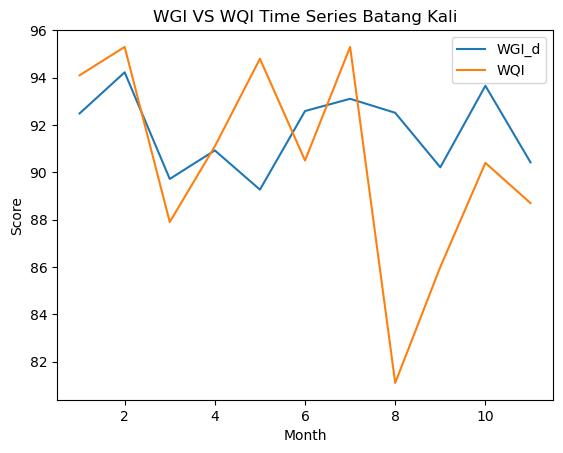

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Kuala Kubu Bharu')

Text(0, 0.5, 'Score')

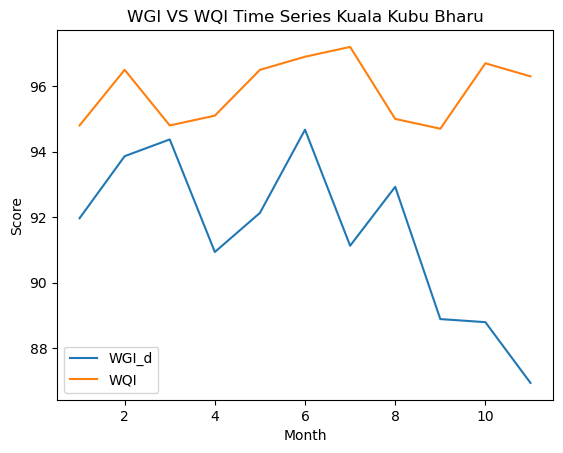

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang New')

Text(0, 0.5, 'Score')

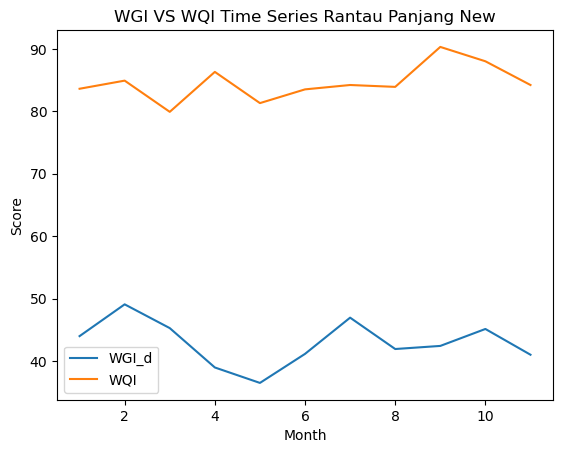

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang Old')

Text(0, 0.5, 'Score')

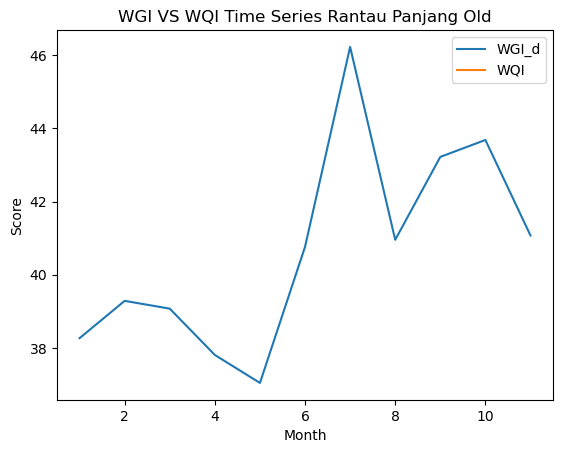

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rasa')

Text(0, 0.5, 'Score')

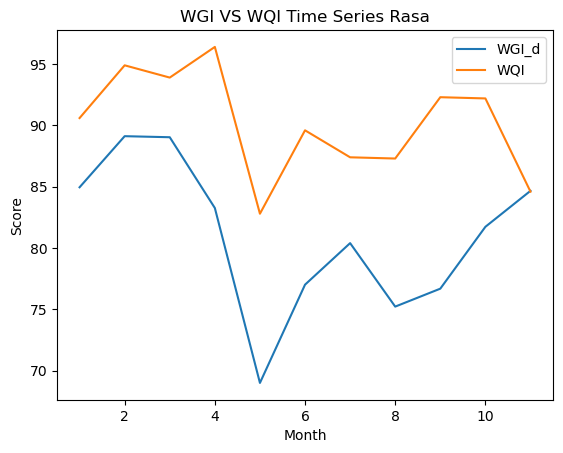

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Rangkap')

Text(0, 0.5, 'Score')

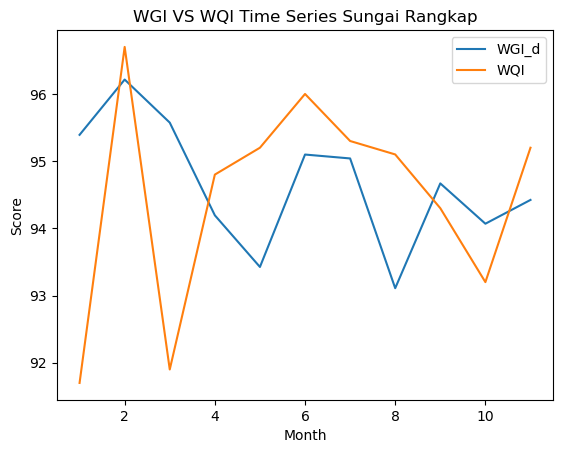

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 1')

Text(0, 0.5, 'Score')

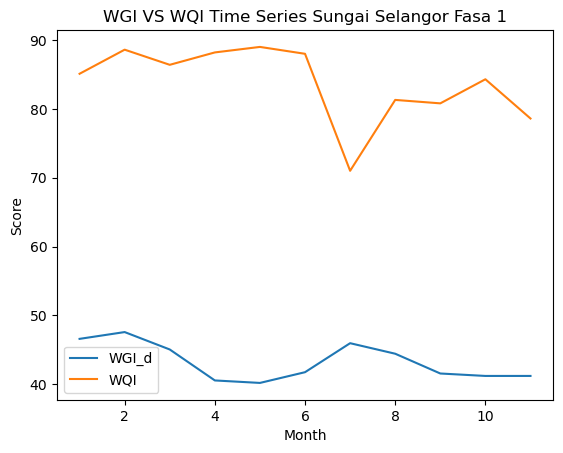

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 2 Stream C')

Text(0, 0.5, 'Score')

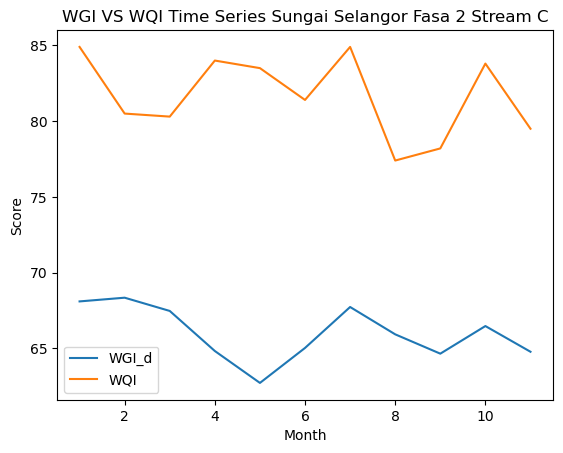

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 3')

Text(0, 0.5, 'Score')

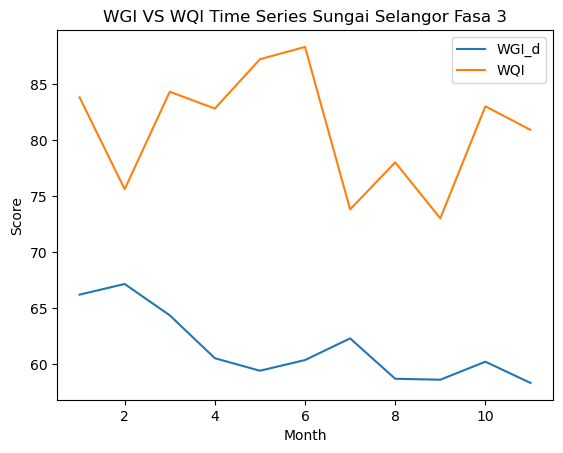

In [35]:
## General Plot to see how the WQI & WGI Differences
for i in c[c['Lembangan'] == 'Sg Selangor']['wtp'].unique():
    c[c['wtp']==i].plot(x='Month',y=['WGI_d','WQI'])
    plt.title(f'WGI VS WQI Time Series {i}')
    plt.ylabel('Score')
    plt.show()

### WGI/WQI VS Actual Monthly Chemical Consumption (Linear Correlation)

In [36]:
## Loading Chemical File & Perform Data Regrouping
chedf = pd.read_csv('checons.csv')
chedf = chedf.rename(columns={'Flopam AH 912 PWG (25kg / bag).1':'Flopam AH 912 PWG (25kg / bag)'})
mdict = dict(zip(chedf['Month'].unique(),np.array(range(1,13,1))))
chedf['Month'] = chedf['Month'].apply(lambda x: mdict.get(x))
cgr = pd.read_csv("C.Grouping.csv")
cgr = cgr.rename(columns={'Chemical Name':'Chem'})

In [37]:
newdb = pd.merge(pd.DataFrame({'Chem':chedf.columns}),cgr,on='Chem',how='inner')
coa = newdb[newdb['Correct Grouping']=='Coagulant']['Chem'].unique()
pha = newdb[newdb['Correct Grouping']=='pH Adjuster']['Chem'].unique()
dis = newdb[newdb['Correct Grouping']=='Disinfectant']['Chem'].unique()

In [38]:
chedf['Coagulant'] = chedf[coa].sum(axis=1)
chedf['pH Adjuster'] = chedf[pha].sum(axis=1)
chedf['Disinfectant'] = chedf[dis].sum(axis=1)

In [39]:
fcl = ['Month', 'wtp', 'Coagulant','pH Adjuster', 'Disinfectant']
db1 = chedf[fcl].copy()
c2 = pd.merge(c,db1,on=['wtp','Month'],how='left')

In [40]:
sum_jam4 = jam4.groupby(['wtp','Month'])['Soda_Ash','Liquid_Chlorine','Liquid_Polyaluminium_Chloride','Hydrated_Lime','Aluminium_Sulphate'].sum().reset_index()

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [41]:
fcl = ['Month', 'wtp', 'Soda_Ash',	'Liquid_Chlorine',	'Liquid_Polyaluminium_Chloride',	'Hydrated_Lime',	'Aluminium_Sulphate']
db1 = sum_jam4[fcl].copy()
c2 = pd.merge(c[c['Lembangan']== 'Sg Selangor'],db1,on=['wtp','Month'],how='left')


In [42]:
## General Correlation Between Chemical Products & WGI/WQI
for i in c2['wtp'].unique():
    print(i)
    c2[c2['wtp']== i][['wtp','WQI','WGI_d','Soda_Ash',	'Liquid_Chlorine',	'Liquid_Polyaluminium_Chloride',	'Hydrated_Lime',	'Aluminium_Sulphate']].corr()

Batang Kali


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,0.228126,0.094646,-0.537223,NaN,NaN,-0.503341
WGI_d,0.228126,1.000000,-0.134819,-0.368967,NaN,NaN,-0.672720
Soda_Ash,0.094646,-0.134819,1.000000,-0.034117,NaN,NaN,0.259724
Liquid_Chlorine,-0.537223,-0.368967,-0.034117,1.000000,NaN,NaN,0.361933
Liquid_Polyaluminium_Chloride,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hydrated_Lime,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluminium_Sulphate,-0.503341,-0.672720,0.259724,0.361933,NaN,NaN,1.000000


Kuala Kubu Bharu


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,-0.036106,-0.150898,-0.173653,NaN,NaN,-0.026231
WGI_d,-0.036106,1.000000,-0.132434,-0.125623,NaN,NaN,-0.911310
Soda_Ash,-0.150898,-0.132434,1.000000,0.962250,NaN,NaN,0.116681
Liquid_Chlorine,-0.173653,-0.125623,0.962250,1.000000,NaN,NaN,0.073010
Liquid_Polyaluminium_Chloride,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hydrated_Lime,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluminium_Sulphate,-0.026231,-0.911310,0.116681,0.073010,NaN,NaN,1.000000


Rantau Panjang New


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,0.102753,NaN,0.104482,-0.088382,-0.250051,NaN
WGI_d,0.102753,1.000000,NaN,-0.503198,-0.966776,-0.303039,NaN
Soda_Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liquid_Chlorine,0.104482,-0.503198,NaN,1.000000,0.619358,0.851763,NaN
Liquid_Polyaluminium_Chloride,-0.088382,-0.966776,NaN,0.619358,1.000000,0.398306,NaN
Hydrated_Lime,-0.250051,-0.303039,NaN,0.851763,0.398306,1.000000,NaN
Aluminium_Sulphate,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Rantau Panjang Old


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WGI_d,NaN,1.000000,NaN,0.278295,-0.252076,0.190299,NaN
Soda_Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liquid_Chlorine,NaN,0.278295,NaN,1.000000,0.387228,0.900468,NaN
Liquid_Polyaluminium_Chloride,NaN,-0.252076,NaN,0.387228,1.000000,0.396418,NaN
Hydrated_Lime,NaN,0.190299,NaN,0.900468,0.396418,1.000000,NaN
Aluminium_Sulphate,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Rasa


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,0.623639,NaN,-0.684962,-0.331705,-0.559395,NaN
WGI_d,0.623639,1.000000,NaN,-0.801749,0.106306,-0.424499,NaN
Soda_Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liquid_Chlorine,-0.684962,-0.801749,NaN,1.000000,-0.043811,0.599603,NaN
Liquid_Polyaluminium_Chloride,-0.331705,0.106306,NaN,-0.043811,1.000000,0.513256,NaN
Hydrated_Lime,-0.559395,-0.424499,NaN,0.599603,0.513256,1.000000,NaN
Aluminium_Sulphate,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sungai Rangkap


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,-0.092613,-0.132836,-0.376739,NaN,NaN,0.048012
WGI_d,-0.092613,1.000000,-0.865183,-0.271573,NaN,NaN,-0.925922
Soda_Ash,-0.132836,-0.865183,1.000000,0.220531,NaN,NaN,0.937444
Liquid_Chlorine,-0.376739,-0.271573,0.220531,1.000000,NaN,NaN,0.082178
Liquid_Polyaluminium_Chloride,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hydrated_Lime,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluminium_Sulphate,0.048012,-0.925922,0.937444,0.082178,NaN,NaN,1.000000


Sungai Selangor Fasa 1


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,-0.184983,NaN,-0.144511,-0.202049,-0.438310,NaN
WGI_d,-0.184983,1.000000,NaN,-0.818255,-0.562749,-0.340730,NaN
Soda_Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liquid_Chlorine,-0.144511,-0.818255,NaN,1.000000,0.691966,0.522300,NaN
Liquid_Polyaluminium_Chloride,-0.202049,-0.562749,NaN,0.691966,1.000000,0.729747,NaN
Hydrated_Lime,-0.438310,-0.340730,NaN,0.522300,0.729747,1.000000,NaN
Aluminium_Sulphate,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sungai Selangor Fasa 2 Stream C


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,0.162712,NaN,0.191028,NaN,0.053166,-0.238798
WGI_d,0.162712,1.000000,NaN,-0.392174,NaN,-0.617441,-0.689767
Soda_Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liquid_Chlorine,0.191028,-0.392174,NaN,1.000000,NaN,0.259425,0.571445
Liquid_Polyaluminium_Chloride,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hydrated_Lime,0.053166,-0.617441,NaN,0.259425,NaN,1.000000,0.414266
Aluminium_Sulphate,-0.238798,-0.689767,NaN,0.571445,NaN,0.414266,1.000000


Sungai Selangor Fasa 3


,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,-0.045431,NaN,0.000479,0.283006,0.022097,NaN
WGI_d,-0.045431,1.000000,NaN,-0.100274,-0.661176,-0.739901,NaN
Soda_Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liquid_Chlorine,0.000479,-0.100274,NaN,1.000000,0.046627,0.200541,NaN
Liquid_Polyaluminium_Chloride,0.283006,-0.661176,NaN,0.046627,1.000000,0.321223,NaN
Hydrated_Lime,0.022097,-0.739901,NaN,0.200541,0.321223,1.000000,NaN
Aluminium_Sulphate,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
c3 = c2.copy()
for i in chem:
    c3[i] = c3[i].replace(0, pd.np.nan)

NameError: name 'chem' is not defined

In [ ]:
c2[['wtp','WQI','WGI_d','Soda_Ash','Liquid_Chlorine','Liquid_Polyaluminium_Chloride','Hydrated_Lime','Aluminium_Sulphate']].corr()

,WQI,WGI_d,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate
WQI,1.000000,0.683885,0.608938,-0.609038,-0.461651,-0.736750,-0.203005
WGI_d,0.683885,1.000000,0.664617,-0.570479,-0.668427,-0.586018,0.197353
Soda_Ash,0.608938,0.664617,1.000000,-0.645656,-0.612511,-0.672795,0.087239
Liquid_Chlorine,-0.609038,-0.570479,-0.645656,1.000000,0.220684,0.596160,0.345152
Liquid_Polyaluminium_Chloride,-0.461651,-0.668427,-0.612511,0.220684,1.000000,0.434649,-0.570904
Hydrated_Lime,-0.736750,-0.586018,-0.672795,0.596160,0.434649,1.000000,0.341038
Aluminium_Sulphate,-0.203005,0.197353,0.087239,0.345152,-0.570904,0.341038,1.000000


In [ ]:
c3 = c2.copy()

### WGI/WQI VS Actual Monthly Chemical Consumption (Elasticity of Grading)

In [ ]:
# for k in c3['wtp'].unique():
#     c2 = c3[c3['wtp'] == k]
    
#     the_name = ['pH_Sc', 'SS_sc', 'Co_Sc', 'Iron_Sc', 'Amm_Sc', 'Mgn_Sc', 'WGI','SIpH', 'SIDO', 'SISS', 'SIBOD', 'SICOD', 'SIAN','WQI','WGI_c','WGI_d', 'Soda_Ash',	'Liquid_Chlorine',	'Liquid_Polyaluminium_Chloride',	'Hydrated_Lime',	'Aluminium_Sulphate']
#     ## Generate Daily % Changed 

#     for i in the_name:
#         c2[f'{i}_chpctm'] = (c2.groupby('wtp')[i].shift(1)-c2[i])/c2[i]
        
#     ## Parameters To Focus
#     tfi2 = ['Liquid_Chlorine_chpctm','Liquid_Polyaluminium_Chloride_chpctm','Hydrated_Lime_chpctm','Aluminium_Sulphate_chpctm','Soda_Ash_chpctm']
#     for i in tfi2:
#         c2[f'Elas_WGI_G{i}'] = c2[i]/c2['WGI_chpctm']
#         c2[f'Elas_WQI_{i}'] = c2[i]/c2['WQI_chpctm']
#         c2[f'Elas_WGI_c{i}'] = c2[i]/c2['WGI_c_chpctm']
#         c2[f'Elas_WGI_d{i}'] = c2[i]/c2['WGI_d_chpctm']
    
#     mdict = {'Parameters':[],'Median':[],'Count':[],'+ve_inf':[],'-ve_inf':[],'0_count':[]}
#     for i in lll:
#         temp = c2[i].copy()
#         temp1 = temp[~temp.isin([np.nan, np.inf, -np.inf,0])]
#         mdict['Parameters'].append(i)
#         mdict['Median'].append(temp1.median()) ## Get Median due to a good measure when there are outliers
#         mdict['Count'].append(temp1.count())
#         mdict['+ve_inf'].append(temp[temp.isin([np.inf])].count())
#         mdict['-ve_inf'].append(temp[temp.isin([-np.inf])].count())
    #     mdict['0_count'].append(temp[temp.isin([0])].count())
    
    # result = pd.DataFrame(mdict)
    
    # result[result['Parameters'].isin(lmd)]
    # print(k)
        

In [ ]:
the_name = ['pH_Sc', 'SS_sc', 'Co_Sc', 'Iron_Sc', 'Amm_Sc', 'Mgn_Sc', 'WGI','SIpH', 'SIDO', 'SISS', 'SIBOD', 'SICOD', 'SIAN','WQI','WGI_c','WGI_d', 'Soda_Ash',	'Liquid_Chlorine',	'Liquid_Polyaluminium_Chloride',	'Hydrated_Lime',	'Aluminium_Sulphate']
## Generate Daily % Changed 
for i in the_name:
    c2[f'{i}_chpctm'] = (c2.groupby('wtp')[i].shift(1)-c2[i])/c2[i]
    
## Parameters To Focus
tfi2 = ['Liquid_Chlorine_chpctm','Liquid_Polyaluminium_Chloride_chpctm','Hydrated_Lime_chpctm','Aluminium_Sulphate_chpctm','Soda_Ash_chpctm']

In [ ]:
for i in tfi2:
    c2[f'Elas_WGI_G{i}'] = c2[i]/c2['WGI_chpctm']
    c2[f'Elas_WQI_{i}'] = c2[i]/c2['WQI_chpctm']
    c2[f'Elas_WGI_c{i}'] = c2[i]/c2['WGI_c_chpctm']
    c2[f'Elas_WGI_d{i}'] = c2[i]/c2['WGI_d_chpctm']

In [ ]:
lmo = [x for x in c2.columns if "Elas_WGI_G" in x]
lmc = [x for x in c2.columns if "Elas_WGI_c" in x]
lmd = [x for x in c2.columns if "Elas_WGI_d" in x]
lmi = [x for x in c2.columns if "Elas_WQI_" in x]
lll = lmo + lmi + lmc + lmd

In [ ]:
mdict = {'Parameters':[],'Median':[],'Count':[],'+ve_inf':[],'-ve_inf':[],'0_count':[]}
for i in lll:
    temp = c2[i].copy()
    temp1 = temp[~temp.isin([np.nan, np.inf, -np.inf,0])]
    mdict['Parameters'].append(i)
    mdict['Median'].append(temp1.median()) ## Get Median due to a good measure when there are outliers
    mdict['Count'].append(temp1.count())
    mdict['+ve_inf'].append(temp[temp.isin([np.inf])].count())
    mdict['-ve_inf'].append(temp[temp.isin([-np.inf])].count())
    mdict['0_count'].append(temp[temp.isin([0])].count())

In [ ]:
result = pd.DataFrame(mdict)
result[result['Parameters'].isin(lmi + lmd)]

,Parameters,Median,Count,+ve_inf,-ve_inf,0_count
5,Elas_WQI_Liquid_Chlorine_chpctm,-0.245603,80,0,0,0
6,Elas_WQI_Liquid_Polyaluminium_Chloride_chpctm,-0.394012,40,0,0,0
7,Elas_WQI_Hydrated_Lime_chpctm,-0.394322,50,0,0,0
8,Elas_WQI_Aluminium_Sulphate_chpctm,-1.040555,39,0,1,0
9,Elas_WQI_Soda_Ash_chpctm,-0.272428,29,0,1,0
15,Elas_WGI_dLiquid_Chlorine_chpctm,-0.674196,90,0,0,0
16,Elas_WGI_dLiquid_Polyaluminium_Chloride_chpctm,-1.096713,50,0,0,0
17,Elas_WGI_dHydrated_Lime_chpctm,-0.801483,60,0,0,0
18,Elas_WGI_dAluminium_Sulphate_chpctm,-6.871410,39,0,1,0
19,Elas_WGI_dSoda_Ash_chpctm,-3.472892,29,0,1,0


## Unit Cost Comparison

In [44]:
uc = pd.read_csv('unit_cost_v2.csv')
uc = uc.rename(columns={'n_wtp':'wtp','UnitCost (cent per m3)':'Unit_cost'})
uc1 = uc[uc['Year']==2021].copy()

In [45]:
fc = pd.merge(c,uc1[['wtp','Month','Unit_cost']],on=['wtp','Month'],how='left')

## Graph

t-value = 1647.027, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Batang Kali Corr:-0.14')

Text(0, 0.5, 'Score')

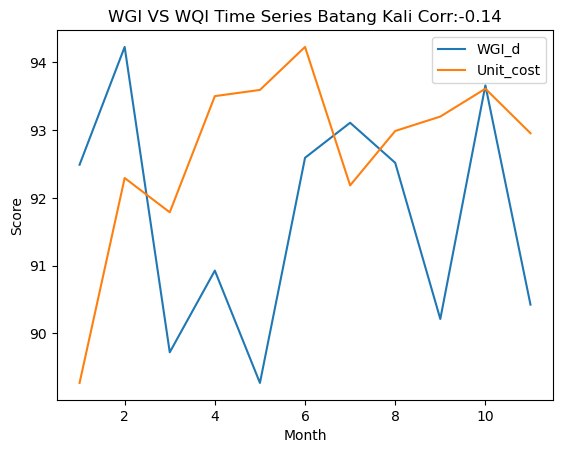

<AxesSubplot:>

Text(0.5, 1.0, 'Batang Kali')

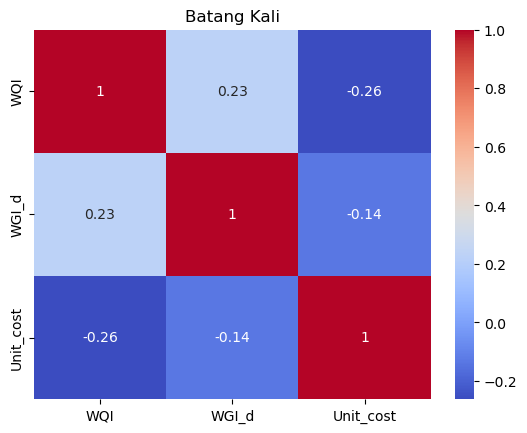

t-value = 2204.051, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Kuala Kubu Bharu Corr:-0.75')

Text(0, 0.5, 'Score')

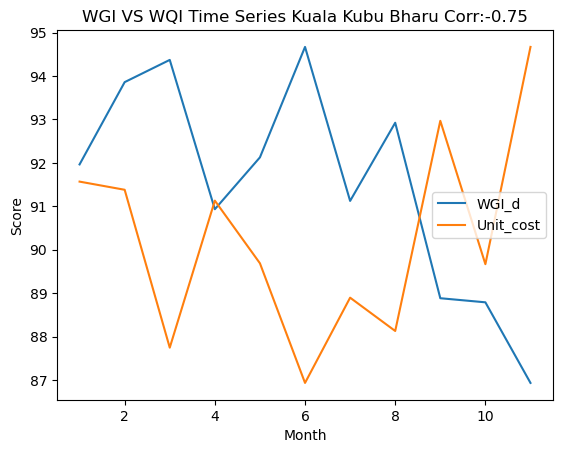

<AxesSubplot:>

Text(0.5, 1.0, 'Kuala Kubu Bharu')

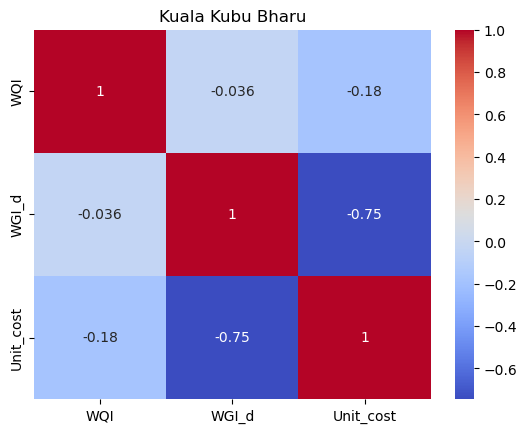

t-value = 649.184, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang New Corr:-0.18')

Text(0, 0.5, 'Score')

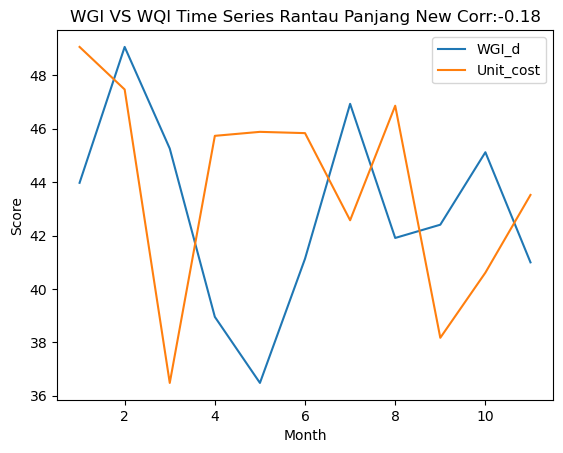

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang New')

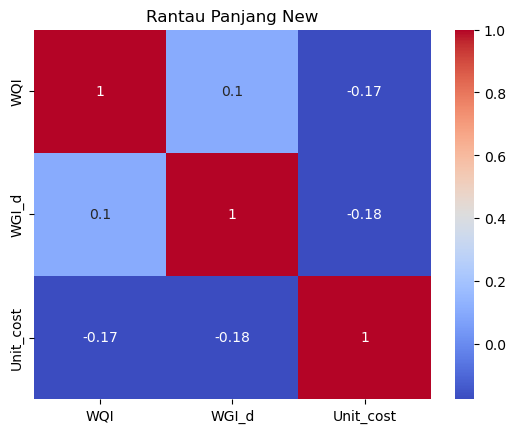

t-value = nan, p-value = nan


All-NaN slice encountered
All-NaN slice encountered


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang Old Corr:nan')

Text(0, 0.5, 'Score')

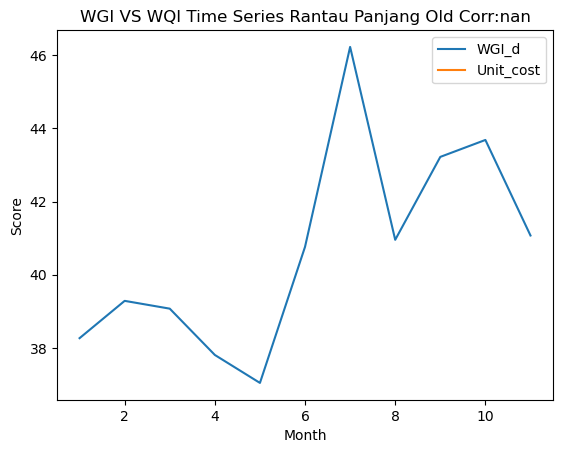

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang Old')

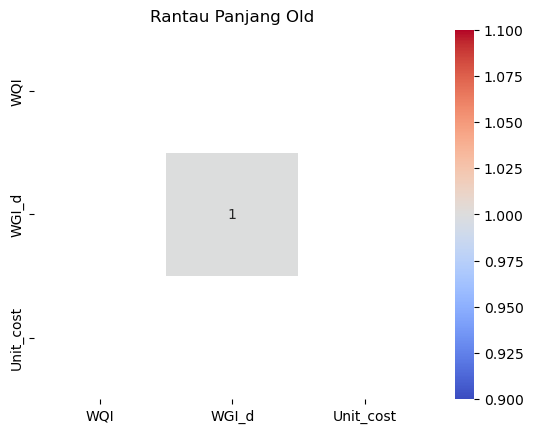

t-value = 838.163, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rasa Corr:-0.42')

Text(0, 0.5, 'Score')

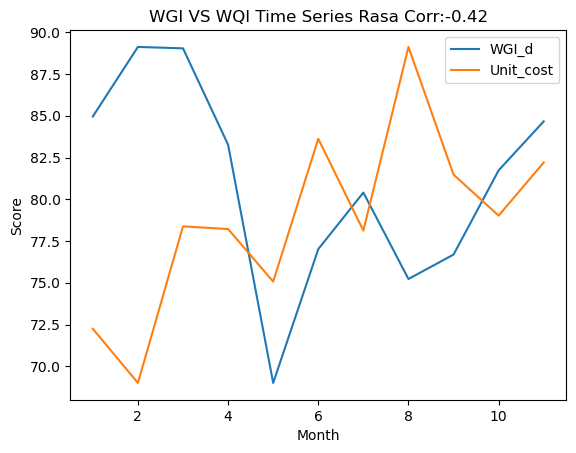

<AxesSubplot:>

Text(0.5, 1.0, 'Rasa')

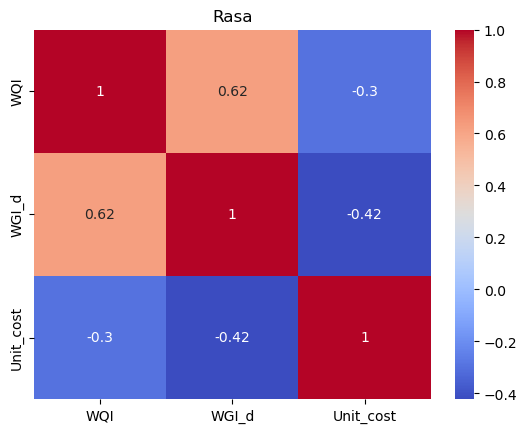

t-value = 4966.055, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Rangkap Corr:-0.1')

Text(0, 0.5, 'Score')

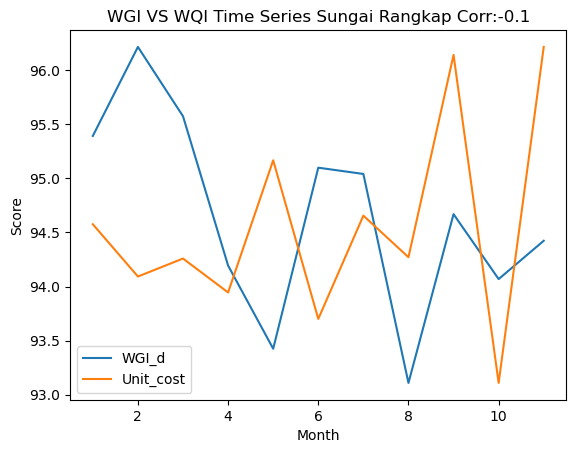

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Rangkap')

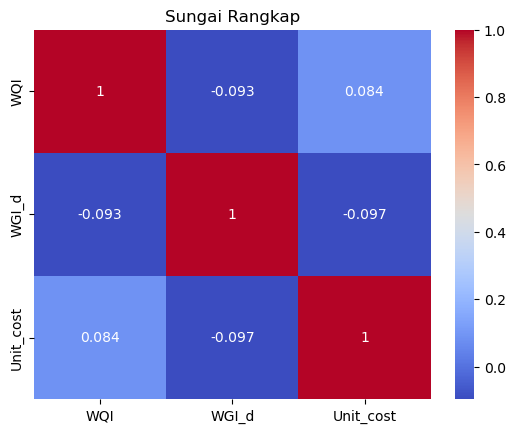

t-value = 986.156, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 1 Corr:-0.85')

Text(0, 0.5, 'Score')

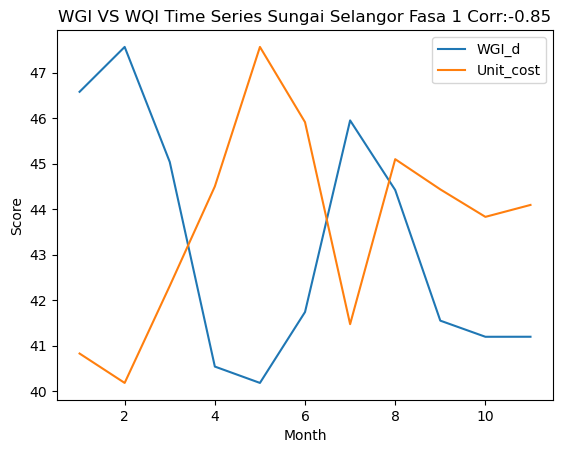

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1')

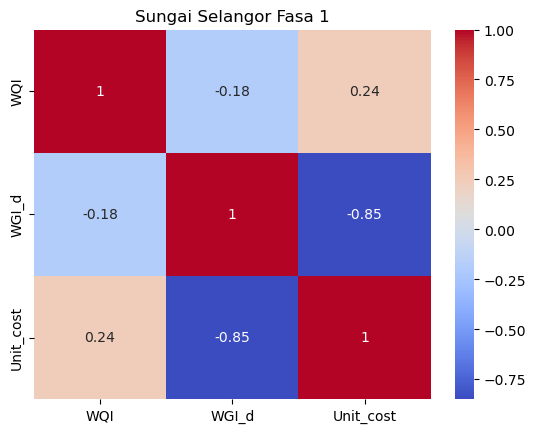

t-value = 2162.196, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 2 Stream C Corr:-0.9')

Text(0, 0.5, 'Score')

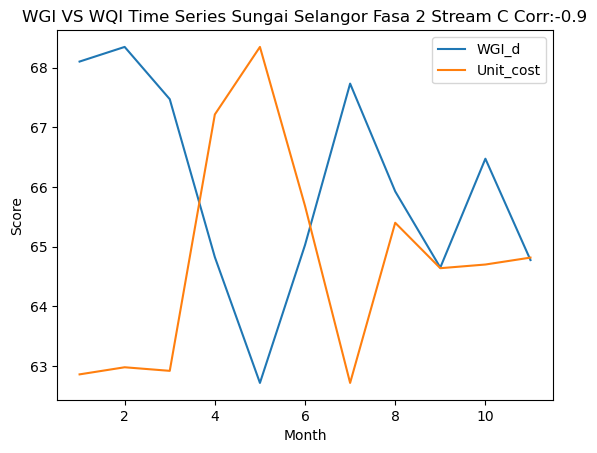

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C')

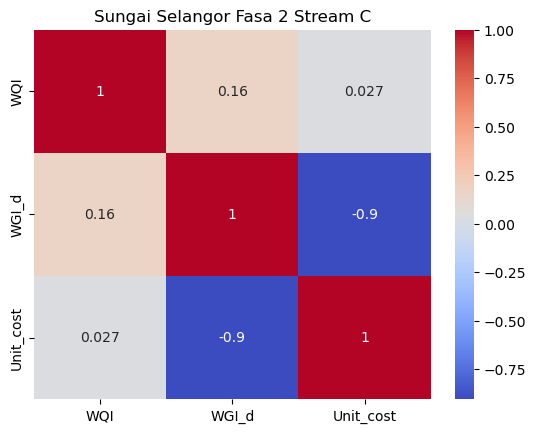

t-value = 171.906, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 3 Corr:0.18')

Text(0, 0.5, 'Score')

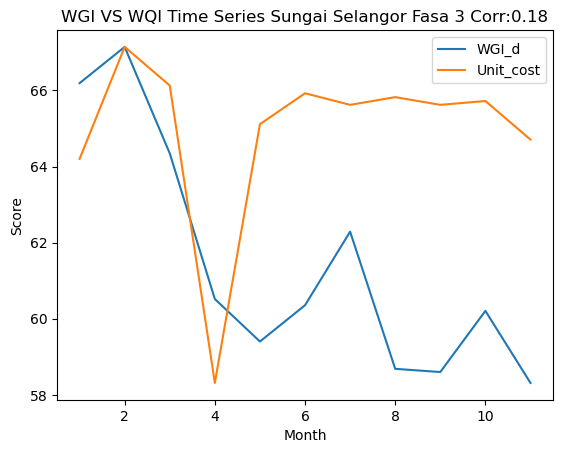

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3')

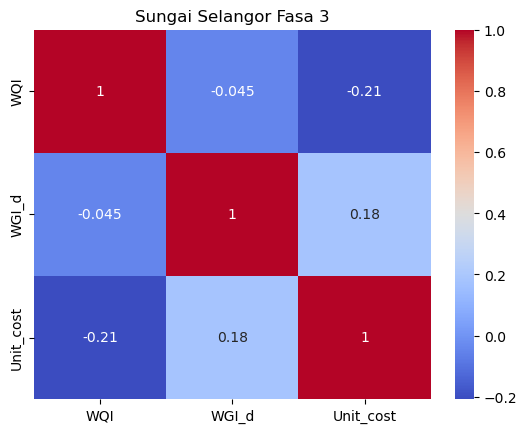

In [47]:
fr = pd.merge(fc,master_db[['wtp']],on = 'wtp',how = 'left')

# define the conditions
#condition = (fr['wtp'] == 'Kuala Kubu Bharu') | (fr['wtp'] == 'Batang Kali')| (fr['wtp'] == 'Sungai Rangkap')
# use loc to update the values
#fr.loc[condition, 'Lembangan'] = 'Sungai Selangor Upstream'

#fr = fr[(fr['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (fr['wtp'] != 'Bukit Tampoi New') & (fr['wtp'] != 'Salak Tinggi')& (fr['wtp'] != 'Sungai Serai') ]
fr = fr[(fr['Lembangan'] == 'Sg Selangor')]
# for i in c['wtp'].unique():
#     c[c['wtp']==i].plot(x='Month',y=['WGI_d','WQI'])
#     plt.title(f'WGI VS WQI Time Series {i}')
#     plt.ylabel('Score')
#     plt.show()
#fr[['Unit_cost']] = fr[['Unit_cost']].multiply(10)
columns_target = 'wtp'
core_unit_wgi = []
core_unit_wqi = []
wtp_corr = []
#columns_target = 'Lembangan'
for i in fr[columns_target].unique():
    # fr[fr[columns_target]==i].plot(x='Month',y=['WGI_d'])
    # plt.title(f'WGI Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    # fr[fr[columns_target]==i].plot(x='Month',y=['Unit_cost'])
    # plt.title(f'Unit Cost Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    core = fr[fr[columns_target] == i][['WQI','WGI_d','Unit_cost']].corr()
    core_unit_wgi.append(core['Unit_cost'][1])
    corr_val =round(core['Unit_cost'][1],2)
    core_unit_wqi.append(core['Unit_cost'][0])
    #for i in c['wtp'].unique():
    
    a = fr[fr['wtp']==i].copy()
    t, p = stats.ttest_ind(a['WGI_d'], a['Unit_cost'])

    # print the results
    print("t-value = {:.3f}, p-value = {:.3f}".format(t, p))
    scaler = MinMaxScaler(feature_range=(a['WGI_d'].min(), a['WGI_d'].max()))
    a['Unit_cost'] = scaler.fit_transform(a[['Unit_cost']])
    a.plot(x='Month',y=['WGI_d','Unit_cost'])
    plt.title(f'WGI VS WQI Time Series {i} Corr:{corr_val}')
    plt.ylabel('Score')
    #save = f'Plot/Sg_Sel/{i}WGI_UnitCost_TimeSeries_plot_Sg_Selangor.png'
    #plt.savefig(save)
    plt.show()
    wtp_corr.append(i) 
    sns.heatmap(core, annot=True, cmap='coolwarm')
    plt.title(i)
    plt.show()
    #save = f'Plot/Sg_Sel/{i}WGI_UnitCost_Corr_plot_Sg_Selangor.png'
    #plt.savefig(save)

data = {'wtp': wtp_corr,
        'corr_wgi_unit': core_unit_wgi,
        'corr_wqi_unit': core_unit_wqi}
  
# Create DataFrame
corr_df = pd.DataFrame(data)

In [687]:
jam4

,wtp,pH_avg,Date,Turbidity_avg,Color_avg,Iron_avg,Ammonia_avg,Manganese_avg,Month,Lembangan,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate,Batang Kali,Kuala Kubu Bharu,Rantau Panjang New,Rantau Panjang Old,Rasa,Sungai Rangkap,Sungai Selangor Fasa 1,Sungai Selangor Fasa 2 Stream C,Sungai Selangor Fasa 3
0,Batang Kali,6.77,2021-04-01,28.75,4.96,0.26,0.28,0.02,4,Sg Selangor,1.05,2.380000,0.000000,0.000000,14.23,1,0,0,0,0,0,0,0,0
1,Batang Kali,6.65,2021-04-02,5.67,0.42,0.22,0.12,0.02,4,Sg Selangor,1.01,2.360000,0.000000,0.000000,13.33,1,0,0,0,0,0,0,0,0
2,Batang Kali,6.61,2021-04-03,14.72,0.42,0.13,0.22,0.02,4,Sg Selangor,0.98,2.260000,0.000000,0.000000,16.47,1,0,0,0,0,0,0,0,0
3,Batang Kali,6.60,2021-04-04,9.50,3.42,0.22,0.47,0.04,4,Sg Selangor,1.03,2.360000,0.000000,0.000000,16.32,1,0,0,0,0,0,0,0,0
4,Batang Kali,6.61,2021-04-05,9.01,0.17,0.14,0.15,0.02,4,Sg Selangor,1.05,2.350000,0.000000,0.000000,17.09,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,Sungai Selangor Fasa 3,5.63,2021-09-26,237.78,31.17,2.98,0.17,0.46,9,Sg Selangor,0.00,6.042845,37.260145,8.515733,0.00,0,0,0,0,0,0,0,0,1
3000,Sungai Selangor Fasa 3,5.52,2021-09-27,196.33,31.92,2.64,0.15,0.55,9,Sg Selangor,0.00,6.514619,41.511501,8.710183,0.00,0,0,0,0,0,0,0,0,1
3001,Sungai Selangor Fasa 3,5.54,2021-09-28,192.42,32.25,1.89,0.20,0.38,9,Sg Selangor,0.00,5.035667,36.873714,8.627555,0.00,0,0,0,0,0,0,0,0,1
3002,Sungai Selangor Fasa 3,5.54,2021-09-29,263.42,26.00,2.63,0.24,0.57,9,Sg Selangor,0.00,5.355148,41.047287,8.724761,0.00,0,0,0,0,0,0,0,0,1


Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<AxesSubplot:title={'center':'SSP2'}, xlabel='Month'>

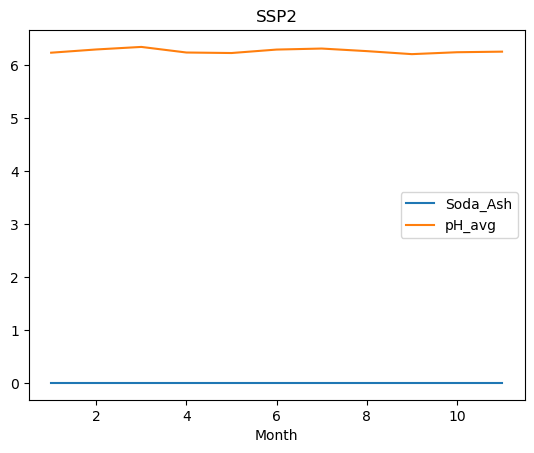

<AxesSubplot:title={'center':'Batang Kali'}, xlabel='Month'>

<AxesSubplot:title={'center':'SSP2'}, xlabel='Month'>

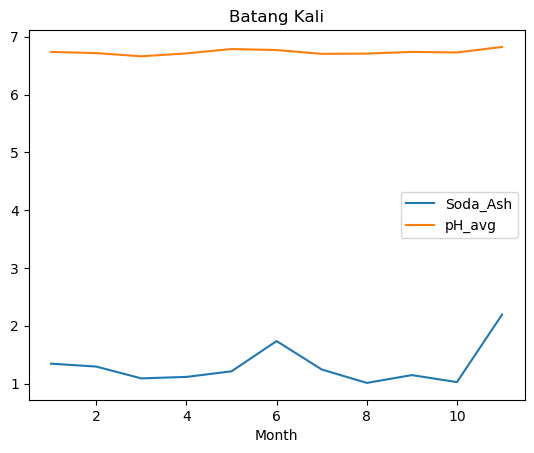

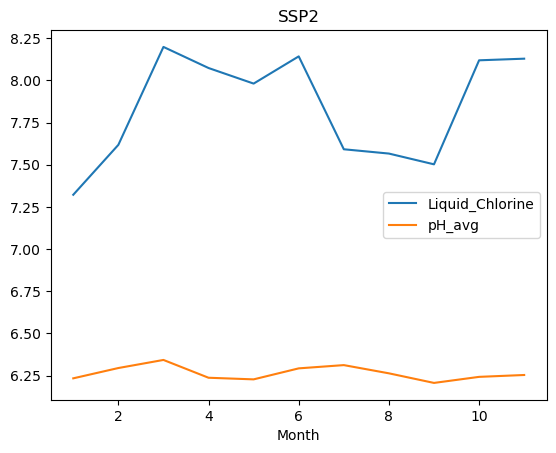

<AxesSubplot:title={'center':'Batang Kali'}, xlabel='Month'>

<AxesSubplot:title={'center':'SSP2'}, xlabel='Month'>

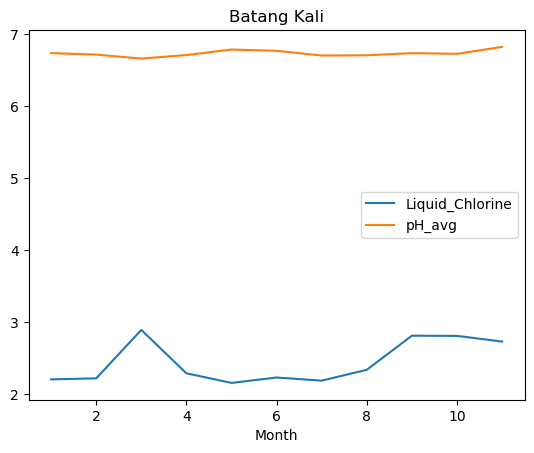

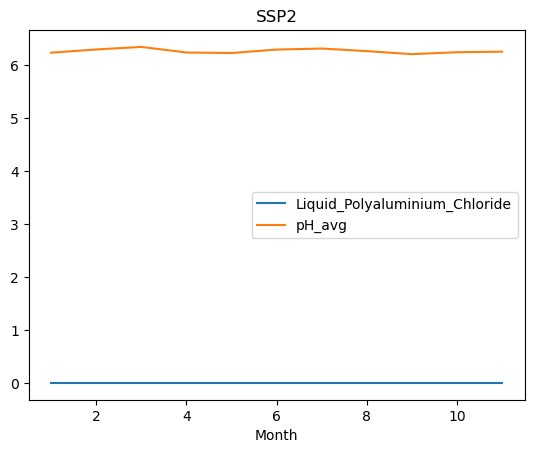

<AxesSubplot:title={'center':'Batang Kali'}, xlabel='Month'>

<AxesSubplot:title={'center':'SSP2'}, xlabel='Month'>

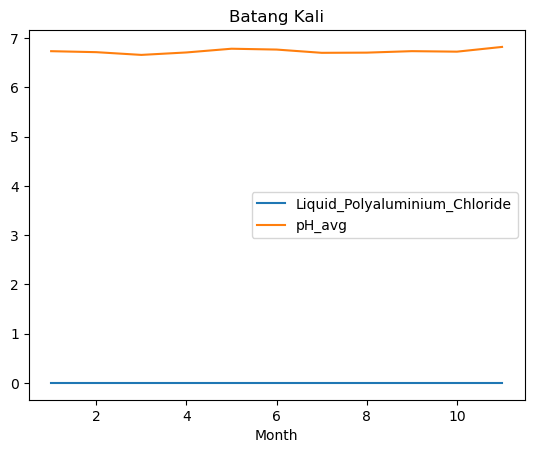

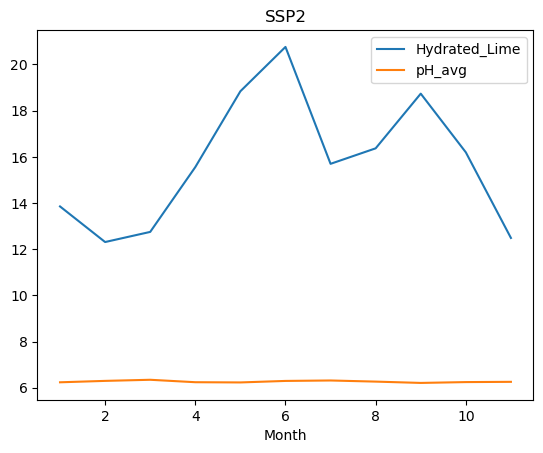

<AxesSubplot:title={'center':'Batang Kali'}, xlabel='Month'>

<AxesSubplot:title={'center':'SSP2'}, xlabel='Month'>

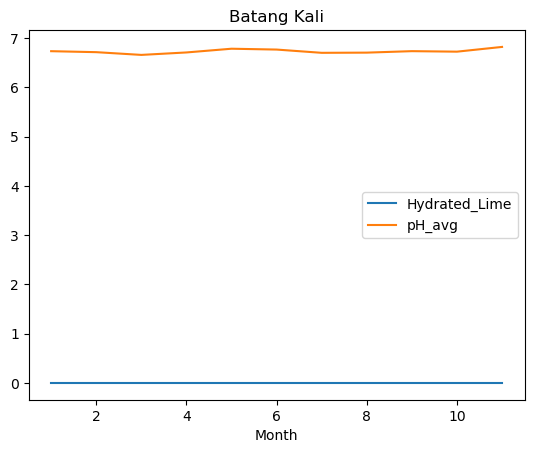

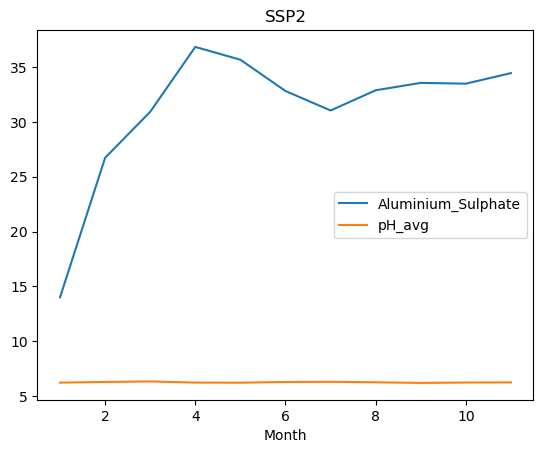

<AxesSubplot:title={'center':'Batang Kali'}, xlabel='Month'>

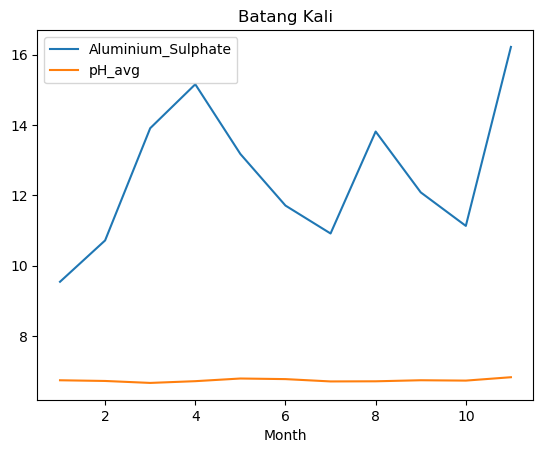

In [688]:
#jam5 = ja
sum_jam4 = jam4.groupby(['wtp','Month'])['pH_avg','Soda_Ash','Liquid_Chlorine','Liquid_Polyaluminium_Chloride','Hydrated_Lime','Aluminium_Sulphate'].mean().reset_index()
for i in chem:
    
    sum_jam4[sum_jam4['wtp']=='Sungai Selangor Fasa 2 Stream C'].plot(x='Month',y=[i,'pH_avg'],title = 'SSP2')
    plt.show()
    sum_jam4[sum_jam4['wtp']=='Batang Kali'].plot(x='Month',y=[i,'pH_avg'],title = 'Batang Kali')

<AxesSubplot:>

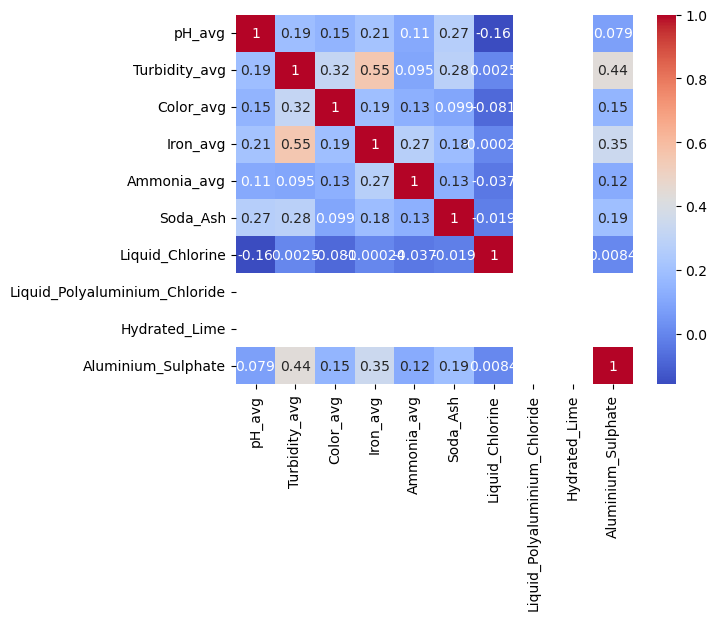

In [698]:
core = jam4[jam4['wtp'] == 'Batang Kali'][[ 'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg','Soda_Ash',
 'Liquid_Chlorine',
 'Liquid_Polyaluminium_Chloride',
 'Hydrated_Lime',
 'Aluminium_Sulphate']].corr()

sns.heatmap(core, annot=True, cmap='coolwarm')

<AxesSubplot:>

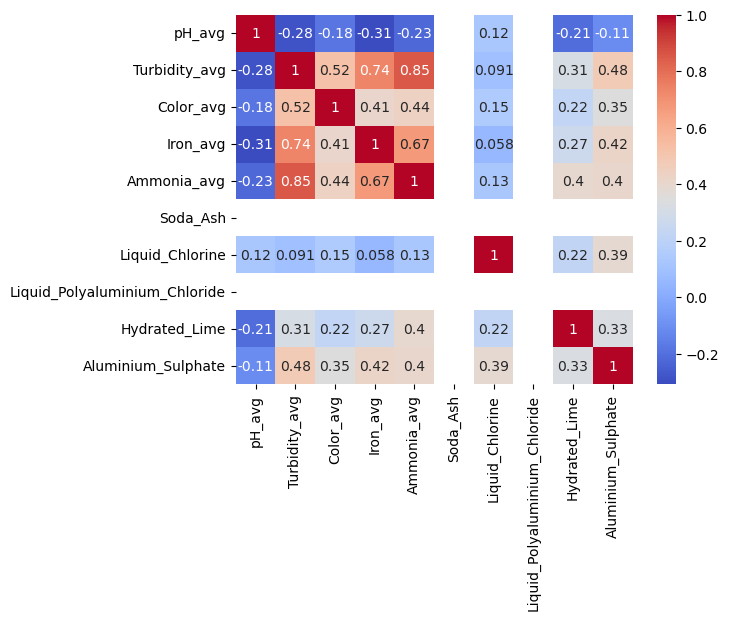

In [699]:
core = jam4[jam4['wtp'] == 'Sungai Selangor Fasa 2 Stream C'][[ 'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg','Soda_Ash',
 'Liquid_Chlorine',
 'Liquid_Polyaluminium_Chloride',
 'Hydrated_Lime',
 'Aluminium_Sulphate']].corr()

sns.heatmap(core, annot=True, cmap='coolwarm')

In [696]:
jam4

,wtp,pH_avg,Date,Turbidity_avg,Color_avg,Iron_avg,Ammonia_avg,Manganese_avg,Month,Lembangan,Soda_Ash,Liquid_Chlorine,Liquid_Polyaluminium_Chloride,Hydrated_Lime,Aluminium_Sulphate,Batang Kali,Kuala Kubu Bharu,Rantau Panjang New,Rantau Panjang Old,Rasa,Sungai Rangkap,Sungai Selangor Fasa 1,Sungai Selangor Fasa 2 Stream C,Sungai Selangor Fasa 3
0,Batang Kali,6.77,2021-04-01,28.75,4.96,0.26,0.28,0.02,4,Sg Selangor,1.05,2.380000,0.000000,0.000000,14.23,1,0,0,0,0,0,0,0,0
1,Batang Kali,6.65,2021-04-02,5.67,0.42,0.22,0.12,0.02,4,Sg Selangor,1.01,2.360000,0.000000,0.000000,13.33,1,0,0,0,0,0,0,0,0
2,Batang Kali,6.61,2021-04-03,14.72,0.42,0.13,0.22,0.02,4,Sg Selangor,0.98,2.260000,0.000000,0.000000,16.47,1,0,0,0,0,0,0,0,0
3,Batang Kali,6.60,2021-04-04,9.50,3.42,0.22,0.47,0.04,4,Sg Selangor,1.03,2.360000,0.000000,0.000000,16.32,1,0,0,0,0,0,0,0,0
4,Batang Kali,6.61,2021-04-05,9.01,0.17,0.14,0.15,0.02,4,Sg Selangor,1.05,2.350000,0.000000,0.000000,17.09,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,Sungai Selangor Fasa 3,5.63,2021-09-26,237.78,31.17,2.98,0.17,0.46,9,Sg Selangor,0.00,6.042845,37.260145,8.515733,0.00,0,0,0,0,0,0,0,0,1
3000,Sungai Selangor Fasa 3,5.52,2021-09-27,196.33,31.92,2.64,0.15,0.55,9,Sg Selangor,0.00,6.514619,41.511501,8.710183,0.00,0,0,0,0,0,0,0,0,1
3001,Sungai Selangor Fasa 3,5.54,2021-09-28,192.42,32.25,1.89,0.20,0.38,9,Sg Selangor,0.00,5.035667,36.873714,8.627555,0.00,0,0,0,0,0,0,0,0,1
3002,Sungai Selangor Fasa 3,5.54,2021-09-29,263.42,26.00,2.63,0.24,0.57,9,Sg Selangor,0.00,5.355148,41.047287,8.724761,0.00,0,0,0,0,0,0,0,0,1


In [694]:
chem

['Soda_Ash',
 'Liquid_Chlorine',
 'Liquid_Polyaluminium_Chloride',
 'Hydrated_Lime',
 'Aluminium_Sulphate']

In [689]:
core['Unit_cost']

WQI         NaN
WGI_d       NaN
Unit_cost   NaN
Name: Unit_cost, dtype: float64

In [690]:
fr.columns

Index(['wtp', 'Month', 'pH_Sc', 'SS_sc', 'Co_Sc', 'Iron_Sc', 'Amm_Sc',
       'Mgn_Sc', 'WGI', 'WGI_c', 'WGI_d', 'DMonth', 'WTP', 'SIpH', 'SIDO',
       'SISS', 'SIBOD', 'SICOD', 'SIAN', 'WQI', 'Diff', 'Lembangan',
       'Unit_cost'],
      dtype='object')

In [691]:
corr_df.sort_values('corr_wgi_unit')  #[corr_df['corr_wgi_unit'] > -0.]#['wtp'].to_list()
corr_df.to_csv('Plot\Result\correlation_unified_weight_WGI_Sg_Selangor_5.csv')

,wtp,corr_wgi_unit,corr_wqi_unit
7,Sungai Selangor Fasa 2 Stream C,-0.904983,0.026807
6,Sungai Selangor Fasa 1,-0.849843,0.238502
1,Kuala Kubu Bharu,-0.745152,-0.183100
4,Rasa,-0.422554,-0.296260
2,Rantau Panjang New,-0.175473,-0.174018
0,Batang Kali,-0.137880,-0.261800
5,Sungai Rangkap,-0.096770,0.084324
3,Rantau Panjang Old,NaN,NaN
8,Sungai Selangor Fasa 3,NaN,NaN


In [66]:
fc.groupby('wtp')[['WGI_d','WQI','Unit_cost']].mean().sort_values(by='WGI_d',ascending=False)

,WGI_d,WQI,Unit_cost
wtp,,,
Sungai Lolo - Baru,95.720776,94.400000,4.527599
Sungai Pangsoon,95.407785,95.154545,3.653661
Sungai Serai,94.712647,95.545455,10.487718
Sungai Rumput,92.395470,93.736364,16.685140
Kalumpang,91.752331,95.545455,4.865266
Labohan Dagang,91.400315,90.100000,6.421107
Sungai Labu,90.552404,81.863636,2.871870
Sungai Rangkap,90.233071,94.490909,4.721915
Semenyih 2,90.133670,79.472727,5.699350
